 ## step1p4_mp.ipynb

This is a version of net_sim_mp.ipynb that is specialized for running parallel versions of step 1 part 3 with a different runner specification for each unit model.


By `Sergio Verduzco`  
August 2018

In [1]:
# import the ei_network class and draculab
%cd ..
from ei_network import *
from pathos.multiprocessing import ProcessingPool
import sys

/home/z/projects/draculab


In [2]:
# This is the name of the file where logging will happen
log_file = "./logs/step1p4_mp" + time.strftime("_%m-%d-%y.txt")

In [3]:
%%capture capt 
# logging draculab version used for this session
print('#======================================================')
print('#             | Latest git commit: |')
print('#====================================================== \n#', end=' ')
!git log -1 --oneline --color=never

In [4]:
# Write the output of the cell above in the simulation log
f = open(log_file, mode='a')
f.write(capt.stdout)
f.close()

In [3]:
#~~~~~~~~~~~~ sigmoidal runner specification ~~~~~~~~~~~~

class s1p4_sig_runner():
    """ A class to run several ei_network objects, each in a different process."""
    def __init__(self, pkl_file=None):
        """ Set parameter values and build the networks. 
        
            Args:
                pkl_file : a string with the file name (including path) of the .pkl file from 
                           an object from this class that was previously dilled. The networks from
                           that object are used for initialization. 
        
            Parameters set:
            name : a name that describes how this version of mp_net_runner is being used.
            n_procs : number of processes to use.
            n_nets : number of networks that will be created.
            n_pres : n_pres[i] = number of input presentations for net 'i'
            pres_t : pres_t[i] = duration of each presentation for net 'i'
            inp_pats : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config.
            inp_funcs : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
            inp_hist1 : inp_hist1[i] = list with ID's of the inputs presented by layer I1 of network 'i'. 
            inp_hist2 : inp_hist2[i] = list with ID's of the inputs presented by layer I2 of network 'i'. 
        """
        self.name = 's1p4mp_sig_test2b'  # a name that describes the use
        self.code = '' # to place the source code in the mp_net_runner class (e.g. this cell)
        self.n_procs = 13  # one per network is good
        self.n_nets = 13
        self.n_pres = [30]*self.n_nets # n_pres[i] = number of input presentations for net 'i'
        self.pres_t = [1.]*self.n_nets # pres_t[i] = duration of each presentation for net 'i'
        self.inp_pats = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_funcs = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_hist1 = [[] for _ in range(self.n_nets)]  
        self.inp_hist2 = [[] for _ in range(self.n_nets)] 
        
        if pkl_file:
            # One way to continue simulations. 
            F = open(pkl_file, 'rb')
            dill_obj = dill.load(F)
            self.nets = dill_obj.nets
            self.input_list = dill_obj.input_list
            self.code = dill_obj.code
            F.close()
            del dill_obj 
            for net in self.nets:
                net.annotate("Network reloaded from pkl file.", make_history=True)
            return   
        
        layers = ['L','I1', 'I2', 'I3', 'LI3', 'D', 'upd', 'des']  
        # L is the representatioan layer, I1,2,3 are the source layers, LI3 is the bidirectionally connected input layer,
        # D is the delta unit, upd signals plasticity updates to D, des is the desired output of D.
        # The sharpening unit for L, LI3, and D is in the x population.
        self.nets = [ei_network(layers, net_number=i) for i in range(self.n_nets)]
        
        # Setting the parameter changes for all networks
        ## First, set baseline changes
        for idx, net in enumerate(self.nets):
            net.annotate('This is network ' + str(idx) + ' in a run of an mp_net_runner object called ' + self.name)
            net.annotate('Based on the s1p4mp_sig_test1 (step1p4_mp_08-17-18.txt), improving the performance of LI3')
            net.annotate('after the I3 inputs are removed. L has sigmoidal units, and LI3 is now 6x10.')
            net.annotate('Other variations include L.e to LI3.i connections, and new connection weights.')
            #net.annotate('10x10 in L.e and 5x5 in L.i without compensating. In here the radius of connection')
            #net.annotate('is increased, the standard tau_scale is decreased, and in the variations to the homeostatic ')
        #----------------------------------
            L = net.layers['L']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
            I3 = net.layers['I3']
            LI3 = net.layers['LI3']
            D = net.layers['D']
            upd = net.layers['upd']
            des = net.layers['des']
        #----------------------------------
            utype_L = unit_types.sigmoidal
            L.annotate('Configuration for %s in L.e' % (utype_L.name))
            L.set_param('e_pars', 'type', utype_L)
            L.set_param('e_pars', 'slope_min', 1.7)
            L.set_param('e_pars', 'slope_wid', .5)
            L.set_param('e_pars', 'thresh_min', 0.)
            L.set_param('e_pars', 'thresh_wid', 0.5)
            L.set_param('e_pars', 'n_ports', 1)
            L.set_param('e_pars', 'branch_params', {'branch_w' : [0.3, 0.7], 'slopes' : 3, 'threshs' : 0.1})
            L.set_param('e_pars', 'tau_slow', 10.)
            L.set_param('e_pars', 'tau_fast', 0.05)
            L.set_param('e_pars', 'c', 3.)
            L.set_param('e_pars', 'tau_scale', .008)
            L.set_param('e_pars', 'tau_relax', 10.)
            L.set_param('e_pars', 'Kp', .02)
            L.set_param('e_pars', 'tau_thr', .01)
            L.set_param('e_pars', 'rdc_port', 0)
            L.set_param('e_pars', 'hr_port', 0)
            L.set_param('e_pars', 'thr_fix', 0.1)
            L.set_param('e_pars', 'tau_fix', 0.1)
            L.set_param('e_pars', 'sharpen_port', 2)
        #----------------------------------
            #L.annotate("Adjusting size of e,i groups, and connection weights.")
            L.set_param('e_geom', 'rows', 10)
            L.set_param('e_geom', 'columns', 10)
            L.set_param('i_geom', 'rows', 5)
            L.set_param('i_geom', 'columns', 5)
            L.set_param('e_geom', 'jitter', 0.)
            L.set_param('i_geom', 'jitter', 0.)
            L.set_param('ee_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.2}})
            L.set_param('ei_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.2}})
            L.set_param('ie_conn', 'weights',{'uniform' : {'low': -1.2, 'high' : -.2}})
            L.set_param('ii_conn', 'weights',{'uniform' : {'low': -1., 'high' : -0.01}})
        #----------------------------------
            #L.annotate("Setting local inputs for L")
            L.set_param('x_geom', 'rows', 0) # one or zero inputs in L, depending on sharpening
            L.set_param('x_geom', 'columns', 1)
            L.set_param('xe_conn', 'mask', {'circular': {'radius': 100.}}) # projecting to all L.e units
            L.set_param('xe_conn', 'kernel', 1.)
            L.set_param('xe_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            L.set_param('xe_syn', 'inp_ports', L.e_pars['sharpen_port'])
            L.set_param('x_pars', 'tau_fast', 0.05)
        #-----------------------------------
            # specifying local input ports
            L.set_param('ee_syn', 'inp_ports', 0)
            L.set_param('ie_syn', 'inp_ports', 0)
        #----------------------------------
            L.annotate("Using static input synapses") # because this is the sharpen input
            L.set_param('xe_syn', 'type', synapse_types.static)
            L.set_param('xe_syn', 'lrate', 1./100.)
            L.set_param('xi_syn', 'type', synapse_types.static)
            L.set_param('xi_syn', 'lrate', 1./100.)
        #----------------------------------
            L.annotate("Using sq_hebbsnorm EE synapses")
            L.set_param('ee_syn', 'type', synapse_types.sq_hebbsnorm)
            L.set_param('ee_syn', 'lrate', 1./100.)
            L.set_param('ee_syn', 'omega', 1.5)
        #----------------------------------
            L.annotate("Using corr_homeo_inhib IE synapses")
            L.set_param('ie_syn', 'type', synapse_types.corr_inh)
            L.set_param('ie_syn', 'lrate', 1./20.)
            L.set_param('ie_syn', 'des_act', 0.3)
        #----------------------------------
            L.annotate("Using static EI synapses")
            L.set_param('ei_syn', 'type', synapse_types.static)
        #----------------------------------
            #I1.annotate("Configuration of I1 geometry")
            I1.set_param('e_geom', 'rows', 0)
            I1.set_param('i_geom', 'rows', 0)
            I1.set_param('x_geom', 'rows', 10)
            I1.set_param('x_geom', 'columns', 1)
            I1.set_param('x_geom', 'extent', [.5, 1.])
            I1.set_param('x_geom', 'center', [-.7, 0.])
        #----------------------------------
            #I2.annotate("Configuration of I2 geometry")
            I2.set_param('e_geom', 'rows', 0)
            I2.set_param('i_geom', 'rows', 0)
            I2.set_param('x_geom', 'rows', 1)
            I2.set_param('x_geom', 'columns', 10)
            I2.set_param('x_geom', 'extent', [1., .5])
            I2.set_param('x_geom', 'center', [0., .7])
        #----------------------------------
            #I3.annotate("Configuration of I3 geometry")
            I3.set_param('e_geom', 'rows', 0)
            I3.set_param('i_geom', 'rows', 0)
            I3.set_param('x_geom', 'rows', 1)
            I3.set_param('x_geom', 'columns', 10)
            I3.set_param('x_geom', 'extent', [1., .5])
            I3.set_param('x_geom', 'center', [0., -1.2])
        #----------------------------------
            L.set_param('n', 'w_track', 16)
            LI3.set_param('n', 'w_track', 16)
            I1.set_param('n', 'w_track', 0)
            I2.set_param('n', 'w_track', 0)
            I3.set_param('n', 'w_track', 0)
        #----------------------------------
        # Layer LI3 parameters
        #----------------------------------
            utype_LI3 = unit_types.sigmoidal
            LI3.annotate("Configuration for %s units in layer LI3." %(utype_LI3.name))
            LI3.set_param('e_pars', 'type', utype_LI3)
            LI3.set_param('e_pars', 'slope_min', 2.)
            LI3.set_param('e_pars', 'slope_wid', .2)
            LI3.set_param('e_pars', 'thresh_min', 0.2)
            LI3.set_param('e_pars', 'thresh_wid', 0.5)
            LI3.set_param('e_pars', 'n_ports', 1)
            LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.3, 0.7], 'slopes' : 3, 'threshs' : 0.1})
            LI3.set_param('e_pars', 'tau_slow', 10.)
            LI3.set_param('e_pars', 'tau_fast', 0.05)
            LI3.set_param('e_pars', 'c', 3.)
            LI3.set_param('e_pars', 'tau_scale', .05)
            LI3.set_param('e_pars', 'tau_relax', 10.)
            LI3.set_param('e_pars', 'Kp', .02)
            LI3.set_param('e_pars', 'tau_thr', .005)
            LI3.set_param('e_pars', 'rdc_port', 0)
            LI3.set_param('e_pars', 'hr_port', 0)
            LI3.set_param('e_pars', 'thr_fix', 0.1)
            LI3.set_param('e_pars', 'tau_fix', 0.1)
            LI3.set_param('e_pars', 'sharpen_port', 2)
            LI3.set_param('i_pars', 'thresh_min', 0.)
        #----------------------------------
            #LI3.annotate("Adjusting e,i groups, and configuring EI,IE connections")
            LI3.set_param('e_geom', 'rows', 6)
            LI3.set_param('e_geom', 'columns', 10)
            LI3.set_param('i_geom', 'rows', 3)
            LI3.set_param('i_geom', 'columns', 5)
            LI3.set_param('e_geom', 'jitter', 0.)
            LI3.set_param('i_geom', 'jitter', 0.)
            LI3.set_param('e_geom', 'extent', [1., .5])
            LI3.set_param('e_geom', 'center', [0., -.8])
            LI3.set_param('i_geom', 'extent', [1., .5])
            LI3.set_param('i_geom', 'center', [0., -.8])
            LI3.set_param('x_geom', 'extent', [1., .5])
            LI3.set_param('x_geom', 'center', [0., -.8])

            LI3.set_param('ee_conn', 'mask', {'circular' : {'radius': 3.}})
            LI3.set_param('ee_conn', 'kernel', {'gaussian' : {'p_center' : 1.1, 'sigma' : .5}})
            LI3.set_param('ee_conn', 'allow_autapses', True)
            LI3.set_param('ee_conn', 'weights', {'gaussian' : {'w_center' : .3, 'sigma' : .2}})

            LI3.set_param('ei_conn', 'mask', {'annular' : {'inner_radius': .2, 'outer_radius' : 0.5}})
            LI3.set_param('ei_conn', 'kernel', 1.)
            LI3.set_param('ei_conn', 'weights',{'ring_gaussian' : {'w_center' : .4, 'sigma' : .1, 'radius' : .3}})

            LI3.set_param('ie_conn', 'mask', {'circular' : {'radius': .5}})
            LI3.set_param('ie_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : 1.}})
            LI3.set_param('ie_conn', 'weights', {'gaussian' : {'w_center' : -2., 'sigma' : .2}})

            LI3.set_param('ii_conn', 'weights',{'uniform' : {'low': -.6, 'high' : -0.2}})
        #----------------------------------
            #LI3.annotate("Setting LI3.x configuration")
            LI3.set_param('x_geom', 'rows', 0) # one or zero inputs in L, depending on sharpening
            LI3.set_param('x_geom', 'columns', 0)
            LI3.set_param('xe_conn', 'mask', {'circular': {'radius': 100.}}) # projecting to all LI3.e units
            LI3.set_param('xe_conn', 'kernel', 1.)
            LI3.set_param('xe_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            LI3.set_param('xe_syn', 'inp_ports', L.e_pars['sharpen_port'])
        #-----------------------------------
        # specifying local input ports
            LI3.set_param('ee_syn', 'inp_ports', 0)
            LI3.set_param('ie_syn', 'inp_ports', 0)
        #----------------------------------
            LI3.annotate("Using static input synapses")
            LI3.set_param('xe_syn', 'type', synapse_types.static)
            LI3.set_param('xi_syn', 'type', synapse_types.static)
        #----------------------------------
            LI3.annotate("Using sq_hebbsnorm EE synapses")
            LI3.set_param('ee_syn', 'type', synapse_types.sq_hebbsnorm)
            LI3.set_param('ee_syn', 'lrate', 1./100.)
            LI3.set_param('ee_syn', 'omega', 1.5)
        #----------------------------------
            LI3.annotate("Using corr_homeo_inhib IE synapses")
            LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
            LI3.set_param('ie_syn', 'lrate', 1./20.)
            LI3.set_param('ie_syn', 'des_act', 0.3)
        #----------------------------------
            LI3.annotate("Using anticov EI synapses")
            LI3.set_param('ei_syn', 'type', synapse_types.anticov)
            LI3.set_param('ei_syn', 'lrate', 1./500.)
        #----------------------------------
        # Delta unit parameters
        #----------------------------------
            utype_D = unit_types.delta_linear
            D.set_param('e_pars', 'type', utype_D)
            D.set_param('e_pars', 'n_ports', 3)
            D.set_param('e_pars', 'tau_slow', 10.)
            D.set_param('e_pars', 'tau_fast', 0.02)
            D.set_param('e_pars', 'gain', 2.)
            D.set_param('e_pars', 'tau_e', .7) # gives roughly 0.5 seconds
            D.set_param('e_pars', 'bias_lrate', .0001)
        #----------------------------------
            #D.annotate("Adjusting size of e,i groups.")
            D.set_param('e_geom', 'rows', 1)
            D.set_param('e_geom', 'columns', 1)
            D.set_param('i_geom', 'rows', 0)
            D.set_param('ee_conn', 'weights',{'uniform' : {'low': 0., 'high' : 0.}})
            D.set_param('ee_conn', 'allow_autapses', False)
        #----------------------------------
            #D.annotate("Setting input parameters")
            D.set_param('x_geom', 'rows', 0) 
            D.set_param('x_geom', 'columns', 0) 
        #----------------------------------
            #upd.annotate("Leaving a single input unit in the upd layer")
            upd.set_param('e_geom', 'rows', 0)
            upd.set_param('i_geom', 'rows', 0)
            upd.set_param('x_geom', 'rows', 1)
            upd.set_param('x_geom', 'columns', 1)
        #----------------------------------
            #upd.annotate("Configuring upd unit")
            upd.set_param('x_pars', 'function', lambda x : None)
            upd.set_param('x_pars', 'init_val', 1.)
            upd.set_param('x_pars', 'coordinates', np.array([0.,0.]))
        #----------------------------------
            #des.annotate("Leaving a single input unit in the des layer")
            des.set_param('e_geom', 'rows', 0)
            des.set_param('i_geom', 'rows', 0)
            des.set_param('x_geom', 'rows', 1)
            des.set_param('x_geom', 'columns', 1)
        #----------------------------------
            #des.annotate("Configuring des unit")
            des.set_param('x_pars', 'function', lambda x : None)
            des.set_param('x_pars', 'init_val', 1.)
            des.set_param('x_pars', 'coordinates', np.array([0.,0.]))
        #----------------------------------
            D.set_param('n', 'w_track', 0)
            upd.set_param('n', 'w_track', 0)
            des.set_param('n', 'w_track', 0)
        #----------------------------------
        # Add interlayer connections
            net.add_connection(('I1','x'), ('L','e'))
            net.add_connection(('I1','x'), ('L','i'))
            net.add_connection(('I2','x'), ('L','e'))
            net.add_connection(('I2','x'), ('L','i'))
            net.add_connection(('I3','x'), ('LI3','e'))
            net.add_connection(('I3','x'), ('LI3','i'))
            net.add_connection(('LI3','e'), ('L','e'))
            net.add_connection(('LI3','e'), ('L','i'))
            net.add_connection(('L','e'), ('LI3','e'))
            net.add_connection(('L','e'), ('LI3','i'))
            net.add_connection(('L','e'), ('D', 'e'))
            net.add_connection(('upd','x'), ('D','e'))
            net.add_connection(('des','x'), ('D','e'))
        #----------------------------------        
        # Configure interlayer connections
            net.set_param('I1x_Le_conn', 'connection_type', 'convergent')
            net.set_param('I1x_Le_conn', 'number_of_connections', 2)
            net.set_param('I1x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Le_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I1x_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
            net.set_param('I1x_Le_conn', 'dist_dim', 'y')
            net.set_param('I1x_Le_conn', 'edge_wrap', True)
            net.set_param('I1x_Le_syn', 'inp_ports', 0)
            net.set_param('I1x_Le_syn', 'type', synapse_types.bcm)
            net.set_param('I1x_Le_syn', 'lrate', 1./50.)
            net.set_param('I1x_Le_syn', 'omega', 1.5)

            net.set_param('I1x_Li_conn', 'connection_type', 'convergent')
            net.set_param('I1x_Li_conn', 'number_of_connections', 2)
            net.set_param('I1x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Li_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I1x_Li_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : 0.5}})
            net.set_param('I1x_Li_conn', 'dist_dim', 'y')
            net.set_param('I1x_Li_conn', 'edge_wrap', True)

            net.set_param('I2x_Le_conn', 'connection_type', 'convergent')
            net.set_param('I2x_Le_conn', 'number_of_connections', 2)
            net.set_param('I2x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Le_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I2x_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
            net.set_param('I2x_Le_conn', 'dist_dim', 'x')
            net.set_param('I2x_Le_conn', 'edge_wrap', True)
            net.set_param('I2x_Le_syn', 'inp_ports', 0)
            net.set_param('I2x_Le_syn', 'type', synapse_types.bcm)
            net.set_param('I2x_Le_syn', 'lrate', 1./50.)
            net.set_param('I2x_Le_syn', 'omega', 1.5)

            net.set_param('I2x_Li_conn', 'connection_type', 'convergent')
            net.set_param('I2x_Li_conn', 'number_of_connections', 2)
            net.set_param('I2x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Li_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I2x_Li_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : 0.5}})
            net.set_param('I2x_Li_conn', 'dist_dim', 'x')
            net.set_param('I2x_Li_conn', 'edge_wrap', True)

            net.set_param('I3x_LI3e_conn', 'mask', {'circular': {'radius': .4}})
            net.set_param('I3x_LI3e_conn', 'kernel', 1.)
            net.set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 2., 'sigma' : .1}})
            net.set_param('I3x_LI3e_conn', 'dist_dim', 'x')
            net.set_param('I3x_LI3e_conn', 'edge_wrap', True)
            net.set_param('I3x_LI3e_syn', 'inp_ports', 0)
            net.set_param('I3x_LI3e_syn', 'type', synapse_types.static)

            net.set_param('I3x_LI3i_conn', 'mask', {'annular' : {'inner_radius': .1, 'outer_radius' : 0.4}})
            net.set_param('I3x_LI3i_conn', 'kernel', 1.)
            net.set_param('I3x_LI3i_conn', 'weights', {'ring_gaussian' : {'w_center' : .4, 'sigma' : .2, 'radius' : .2}})
            net.set_param('I3x_LI3i_conn', 'dist_dim', 'x')
            net.set_param('I3x_LI3i_conn', 'edge_wrap', True)

            def make_l2l_transf(src_geom, trg_geom): 
                # a standard transform for interlayer connections.
                # Scales the source boundary to match the target's, and shifts the centers
                src_cntr = np.array(src_geom['center'])
                trg_cntr = np.array(trg_geom['center'])
                src_extent = src_geom['extent']
                trg_extent = trg_geom['extent']
                shift = trg_cntr - src_cntr
                x_scaling = trg_extent[0] / src_extent[0]
                y_scaling = trg_extent[1] / src_extent[1]
                return lambda x : np.array([x_scaling * x[0], y_scaling * x[1]]) + shift

            net.set_param('LI3e_Le_conn', 'connection_type', 'convergent')
            #net.set_param('LI3e_Le_conn', 'number_of_connections', 5)
            net.set_param('LI3e_Le_conn', 'mask', {'circular': {'radius': .5}})
            net.set_param('LI3e_Le_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : .3}})
            net.set_param('LI3e_Le_conn', 'weights', {'linear' : {'c' : 0.2, 'a' : .2}})
            net.set_param('LI3e_Le_conn', 'edge_wrap', True)
            net.set_param('LI3e_Le_syn', 'inp_ports', 1)
            net.set_param('LI3e_Le_syn', 'type', synapse_types.bcm)
            net.set_param('LI3e_Le_syn', 'lrate', 1./50.)
            net.set_param('LI3e_Le_syn', 'omega', 1.5)

            net.set_param('LI3e_Li_conn', 'connection_type', 'convergent')
            #net.set_param('LI3e_Li_conn', 'number_of_connections', 5)
            net.set_param('LI3e_Li_conn', 'mask', {'circular': {'radius': .5}})
            net.set_param('LI3e_Li_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : .3}})
            net.set_param('LI3e_Li_conn', 'weights', {'linear' : {'c' : 0.2, 'a' : .2}})
            #net.set_param('LI3e_Li_conn', 'dist_dim', 'x')
            net.set_param('LI3e_Li_conn', 'edge_wrap', True)
    
            net.set_param('Le_LI3e_conn', 'connection_type', 'convergent')
            #net.set_param('Le_LI3e_conn', 'number_of_connections', 20)
            net.set_param('Le_LI3e_conn', 'mask', {'circular': {'radius': .5}})
            net.set_param('Le_LI3e_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : .2}})
            net.set_param('Le_LI3e_conn', 'weights', {'linear' : {'c' : 0.1, 'a' : .2}})
            net.set_param('Le_LI3e_conn', 'edge_wrap', True)
            net.set_param('Le_LI3e_conn', 'boundary', {'center':LI3.e_geom['center'], 'extent':LI3.e_geom['extent']})
            net.set_param('Le_LI3e_conn', 'transform', make_l2l_transf(L.e_geom, LI3.e_geom))
            net.set_param('Le_LI3e_syn', 'inp_ports', 1)
            net.set_param('Le_LI3e_syn', 'type', synapse_types.sq_hebbsnorm)
            net.set_param('Le_LI3e_syn', 'lrate', 1./50.)
            net.set_param('Le_LI3e_syn', 'omega', 1.) # for sq_hebbsnorm

            net.set_param('Le_LI3i_conn', 'connection_type', 'convergent')
            #net.set_param('Le_LI3i_conn', 'number_of_connections', 3)
            net.set_param('Le_LI3i_conn', 'mask', {'circular': {'radius': .5}})
            net.set_param('Le_LI3i_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : .2}})
            net.set_param('Le_LI3i_conn', 'weights', {'linear' : {'c' : 0.1, 'a' : .2}})
            net.set_param('Le_LI3i_conn', 'edge_wrap', True)
            net.set_param('Le_LI3i_conn', 'boundary', {'center':LI3.i_geom['center'], 'extent':LI3.i_geom['extent']})
            net.set_param('Le_LI3i_conn', 'transform', make_l2l_transf(L.e_geom, LI3.i_geom))
            net.set_param('Le_LI3i_syn', 'type', synapse_types.sq_hebbsnorm)
            net.set_param('Le_LI3i_syn', 'lrate', 1./50.)
            net.set_param('Le_LI3i_syn', 'omega', 1.) # for sq_hebbsnorm
            
            net.set_param('Le_De_conn', 'connection_type', 'divergent')
            net.set_param('Le_De_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('Le_De_conn', 'kernel', 1.)
            net.set_param('Le_De_conn', 'weights', {'uniform' : {'low' : 0.01, 'high' : .05}})
            net.set_param('Le_De_syn', 'inp_ports', 0)
            net.set_param('Le_De_syn', 'type', synapse_types.delta)
            net.set_param('Le_De_syn', 'lrate', .2)

            net.set_param('updx_De_conn', 'mask',{'circular': {'radius': 10.}})
            net.set_param('updx_De_conn', 'kernel', 1.)
            net.set_param('updx_De_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            net.set_param('updx_De_syn', 'inp_ports', 2)

            net.set_param('desx_De_conn', 'mask',{'circular': {'radius': 10.}})
            net.set_param('desx_De_conn', 'kernel', 1.)
            net.set_param('desx_De_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            net.set_param('desx_De_syn', 'inp_ports', 1)
          
        # Now adjust networks individually
        ### network 0 is the baseline
        # The default network is 0K, although after 20 or so presentations the activity in LI3 and L 
        # becomes too abundant.
        ### network 1
        n = 1
        # All LI3 units went into a static pattern around 0.7; they caused L activity to increase concurrently.
        # Setting slope_min=10, threshs=0
        ## Network is still stuck in some static response pattern.
        ## I'm changing the inhibitory connections so they go to all branches...
        ## err, that's tricky, so I'll set thresh_wid to 0.2, slopes=5, and ie at port 0 instead.
        ### A fixed pattern is stuck. Setting 'branch_w' : [0.2, 0.5, 0.3]
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using ds LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.double_sigma)
        LI3.set_param('e_pars', 'slope_min', 12)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.2, 0.5, 0.3], 'slopes' : 5, 'threshs' : 0.})
        LI3.set_param('ee_syn', 'inp_ports', 0)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 1)
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        ### network 2
        n = 2
        # Activity started centered but sparse, then it kept growing. It may become too much later on, but
        # for the time being I like it, and I'll let it be.
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.sigma_double_sigma)
        LI3.set_param('e_pars', 'slope_min', 10)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.5, 0.5], 'slopes' : 5, 'threshs' : 0.}) 
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.4)
        LI3.set_param('ee_syn', 'inp_ports', 1)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        ### network 3
        n = 3
        # Still having the issue of too much activity.
        # I'm tempted to test the 3-branch configuration, but for the time being I'll let it be
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_trdc LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.sds_trdc)
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        #LI3.set_param('e_pars', 'thresh_min', 0.)
        #LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.5, 0.5], 'slopes' : 4, 'threshs' : 0.3})
        #LI3.set_param('e_pars', 'tau_thr', .005)
        LI3.set_param('e_pars', 'c', 4.)
        LI3.set_param('e_pars', 'rdc_port', 1)  
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        #self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        LI3.set_param('ee_syn', 'inp_ports', 1)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)    
        self.nets[n].set_param('LI3e_Le_syn', 'type', synapse_types.sq_hebbsnorm) # here be experiment
        self.nets[n].set_param('LI3e_Le_syn', 'lrate', 1./50.)
        self.nets[n].set_param('LI3e_Le_syn', 'omega', 1.)
        ### Network 4
        n = 4
        # Activity is a bit sparse and fickle, but I'll let this one be as it is.
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_sharp LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.sds_sharp)
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 4)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.5, 0.5], 'slopes' : 4, 'threshs' : 0.2})
        LI3.set_param('e_pars', 'tau_thr', .01)
        LI3.set_param('e_pars', 'c', 2.)
        LI3.set_param('e_pars', 'rdc_port', 1) 
        LI3.set_param('e_pars', 'thr_fix', 0.) 
        #LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate(">> Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        #self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        LI3.set_param('x_geom', 'rows', 1) # one input in LI3
        LI3.set_param('x_geom', 'columns', 1)
        LI3.set_param('x_pars', 'tau_fast', 0.05)
        LI3.set_param('ee_syn', 'inp_ports', 1)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        LI3.set_param('e_pars', 'sharpen_port', 3) # beware of forgetting this
        LI3.set_param('xe_syn', 'inp_ports', LI3.e_pars['sharpen_port'])
        ### Network 5
        n = 5
        # The response of the units was too small. 
        # Reducing threshs.
        ## The response is still small. 
        ## Reducing thresh_min to 0.1, thresh_wid to 0.2
        ### Activity still decreases over time, but it's not so bad. I'll let it be.
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using double_sigma_n LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.double_sigma_n)
        LI3.set_param('e_pars', 'slope_min', 12)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.1)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.2, 0.5, .3], 'slopes' : 4, 'threshs' : 0.})
        #LI3.set_param('e_pars', 'phi', 0.5)
        LI3.set_param('e_pars', 'tau_slow', 5.)
        LI3.set_param('ee_syn', 'inp_ports', 0)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 1)  
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        self.nets[n].set_param('LI3e_Le_syn', 'type', synapse_types.sq_hebbsnorm) # here be experiment
        self.nets[n].set_param('LI3e_Le_syn', 'lrate', 1./50.)
        self.nets[n].set_param('LI3e_Le_syn', 'omega', 1.)
        ### Network 6
        n = 6
        # Network is big time unstable, with everyone active. 
        # For some reason I had ie_syn in port1, moved it to 0.Increased threshs to 0.1
        ## Really tiny responses.
        ## Set thresh min to 0.1, threshs=0, des_act=.3
        ### Responses are still tiny. 
        ### Removing the Le-LI3e omega change and sq_hebbsnorm synapses, increasing slope_min, decreasing thresh_min
        ### Using faster lrate for corr_inh. Increasing des_act to .4
        #### The latest configuration seems really good. I'll let it be.
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_n LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.sds_n) 
        LI3.set_param('e_pars', 'slope_min', 12)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.})
        LI3.set_param('e_pars', 'tau_slow', 5.)
        LI3.annotate(">> Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./10.)
        LI3.set_param('ie_syn', 'des_act', 0.4)
        LI3.set_param('ee_syn', 'inp_ports', 1)  # This is the key
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        ### Network 7
        n = 7
        # Activity is fickle and somewhat weak, yet some LI3.i units are almost saturated.
        # Moved slopes from 4 to 5
        ## It's getting good, but still a bit fickle and weak, specially at the beginning.
        ## Reduced tau_slow to 5
        ### Still fickle.
        ### Increasing slope_min to 12
        #### Still somewhat fickle, but not bad.
        #### I think the variations in activity come from the interplay of the rdc mechanism with
        #### feedback inhibition, and are a feature that should stay. I'll let it be.
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_n_sharp LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.sds_n_sharp)  # same parameters as sds_sharp
        LI3.set_param('e_pars', 'slope_min', 12)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 4)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 5, 'threshs' : 0.})
        LI3.set_param('e_pars', 'tau_slow', 5.)
        LI3.set_param('e_pars', 'c', 2.)
        LI3.set_param('e_pars', 'rdc_port', 1) 
        LI3.set_param('e_pars', 'thr_fix', 0.)
        LI3.set_param('e_pars', 'tau_thr', .01)
        #LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        #self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        LI3.set_param('x_geom', 'rows', 1) # one input in LI3
        LI3.set_param('x_geom', 'columns', 1)
        LI3.set_param('e_pars', 'sharpen_port', 3) # beware of forgetting this
        LI3.set_param('xe_syn', 'inp_ports', LI3.e_pars['sharpen_port'])
        #LI3.set_param('x_pars', 'tau_fast', 0.05)
        LI3.set_param('ee_syn', 'inp_ports', 1)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        ### Network 8
        n = 8
        # Way too much activity, although the behavior is crisp.
        # Moved slopes from 4 to [3, 2, 3], threshs to 0.2
        ## Still has humongous activity.
        ## Increased thresh_min to 0.2, increased slope_min to 12
        ### I forgot that I had set tau_scale=0.001 for debugging.
        ### Setting tau_scale=0.01
        #### It's doing a decent job right now. I'll let it be.
        LI3 = self.nets[n].layers['LI3'] 
        LI3.annotate(">>> Using ds_ssrdc_sharp LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.ds_ssrdc_sharp)
        LI3.set_param('e_pars', 'slope_min', 12)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.2)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 4)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.3, 0.4, 0.3], 'slopes' : [3., 2., 3.], 'threshs' : 0.2})
        LI3.set_param('e_pars', 'c', 2.)
        LI3.set_param('e_pars', 'tau_scale', .01)
        LI3.set_param('e_pars', 'Kp', .02)
        LI3.set_param('e_pars', 'rdc_port', 0)
        LI3.set_param('x_geom', 'rows', 1) # one input in LI3
        LI3.set_param('x_geom', 'columns', 1)
        #self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 2., 'sigma' : .1}})
        LI3.set_param('ee_syn', 'inp_ports', 0)
        LI3.set_param('ie_syn', 'inp_ports', 0) # sneaky, effective, inhibition goes to strong branch
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 1)
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        LI3.set_param('e_pars', 'sharpen_port', 3)
        LI3.set_param('xe_syn', 'inp_ports', LI3.e_pars['sharpen_port'])
        ### network 9
        n = 9
        # Activity keeps growing, sometimes 6 fully active columns, sometimes none. LI3.i saturated.
        # set ie des_act to 0.2
        ## Still a bit much activity for my taste. Seems like attractors are forming together with L.
        ## Set slope_min=1.5
        ### This looks OK. Time to let it be.
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using trdc LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.sig_trdc)
        LI3.set_param('e_pars', 'slope_min', 1.5)
        LI3.set_param('e_pars', 'slope_wid', .3)
        LI3.set_param('e_pars', 'thresh_min', 0.3)
        LI3.set_param('e_pars', 'thresh_wid', 0.5)
        LI3.set_param('e_pars', 'n_ports', 2)
        LI3.set_param('e_pars', 'c', 3.)
        LI3.set_param('e_pars', 'tau_thr', .002)
        LI3.annotate(">> Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.2)
        LI3.set_param('e_pars', 'rdc_port', 0)
        LI3.set_param('ee_syn', 'inp_ports', 0)
        LI3.set_param('ie_syn', 'inp_ports', 1)
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 1)
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 1)
        ### network 10
        n = 10
        # Introducing sig_ssrdc units
        ## Neat behavior! Sometimes responses were not large enough.
        ## Setting thresh_min = 0.1, thresh_wid = 0.4
        ### Responses are still small
        ### Setting c=2, des_act=0.4, thresh_wid=.2
        #### I like it well enough. Let it be.
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using ssrdc LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.sig_ssrdc)
        LI3.set_param('e_pars', 'thresh_min', 0.1)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 2)
        LI3.set_param('e_pars', 'c', 2.)
        LI3.set_param('e_pars', 'tau_scale', .05)
        LI3.set_param('e_pars', 'Kp', .02)
        #LI3.annotate(">> Using corr_inh IE synapses")
        #LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        #LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.4)
        LI3.set_param('e_pars', 'rdc_port', 0)
        LI3.set_param('ee_syn', 'inp_ports', 0)
        LI3.set_param('ie_syn', 'inp_ports', 1)
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 1)
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 1)
        ### network 11
        n = 11
        # Responses are rather unequal. Inh units are saturated.
        # Will put corr_inh ie connections.
        ## Responses are still unequal. I'll let it be.
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using st_hr_sig LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.st_hr_sig)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'n_ports', 2)
        LI3.set_param('e_pars', 'hr_port', 0)
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ee_syn', 'inp_ports', 0)
        LI3.set_param('ie_syn', 'inp_ports', 1)
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 1)
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 1)
        ### network 12
        n = 12
        # Has a nice response, but units don't reach high values.
        # Increasing slope_min
        ## Still have tiny responses sometimes.
        ## Setting  thresh_wid = 0.3, slope_min=2.3
        ### Responses are still a bit small.
        ### Setting  thresh_wid = 0.2, slope_min=2.5
        #### Looks good. I'll let it be.
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using ss_hr_sig LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.ss_hr_sig)
        LI3.set_param('e_pars', 'slope_min', 2.5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 2)
        LI3.set_param('e_pars', 'hr_port', 0)
        LI3.set_param('ee_syn', 'inp_ports', 0)
        LI3.set_param('ie_syn', 'inp_ports', 1)
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 1)
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 1)
        
        self.build()
                              
    def build(self):
        # Building the networks
        # The point of putting this outside the __init__ method is that if at some point the networks get too
        # big and take a long time to build, you can build them in parallel by creating a build(net_num)
        # method and then calling it from run_all with pool.map(build, range(self.n_nets))
        for net in self.nets:
            net.build()
         
    def inp_pat1(self, pres, n_pat1, n_pat2, random=True):
        """ A function to create input patterns for I1. """
        if random:  
            idx = self.input_list[pres][0] # a list of randomly permuted inputs, from input_config
        else:
            idx = int( np.floor( (pres%(n_pat1*n_pat2)/n_pat2) )  )
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat1)) for x in range(n_pat1)], idx)

    def inp_pat2(self, pres, n_pat1, n_pat2, random=True):
        """ A function to create input patterns for I2. """
        if random:  
            idx = self.input_list[pres][1]
        else:
            mpres = pres%(n_pat1*n_pat2)
            idx = int( np.round( ( mpres % n_pat2) )  )
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat1)) for x in range(n_pat1)], idx)
    
    def I3_fun(self, I1, I2, n_pat3):
        """ The function that produces the I3 input pattern from the I1 and I2 input patterns. """
        return (I1 + I2)%n_pat3
    
    def inp_pat3(self, pres, n_pat1, n_pat2, n_pat3, random=True):
        """ A function to create input patterns for I3. """
        if random:  
            idx = self.input_list[pres][2]
        else:
            mpres = pres%(n_pat1*n_pat2)
            idx = int( self.I3_fun(np.round(mpres % n_pat2), np.floor(mpres / n_pat2), n_pat3) )
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat1)) for x in range(n_pat1)], idx)

    def make_I1_inp(self, n_pat1, n_pat2, net_id, rnd):
        """ Returns a function that is a specific version of self.inp_pat1 suited of the 'net_id' net. """
        return lambda pres, rows, columns, n_id: self.inp_pat1(pres, n_pat1, n_pat2, random=rnd) 
    
    def make_I2_inp(self, n_pat1, n_pat2, net_id, rnd):
        """ Returns a function that is a specific version of self.inp_pat2 suited of the 'net_id' net. """
        return lambda pres, rows, columns, n_id: self.inp_pat2(pres, n_pat1, n_pat2, random=rnd) 
    
    def make_I3_inp(self, n_pat1, n_pat2, n_pat3, net_id, rnd):
        """ Returns a function that is a specific version of self.inp_pat3 suited of the 'net_id' net. """
        return lambda pres, rows, columns, n_id: self.inp_pat3(pres, n_pat1, n_pat2, n_pat3, random=rnd) 

    def make_shrp_fun(self, prev_pat, cur_pat, init_time, pres_time):
        """ Returns a function that goes from 1 to 0 when its argument is close to init_time or init_time+pres_time.
            
            Args:
                prev_pat : 1-D numpy array with the previous input pattern. (not currently used)
                cur_pat : 1-D numpy array with the current input pattern. (not currently used)
                init_time: initial time of this presentation.
                pres_time: duration of this presentation.
        """
        eps = .1 # distance to the input change where sharpening is released
        return lambda t : 0. if (t < init_time+eps or t > init_time+pres_time-eps) else 1.
    
    def set_shrp_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        """ Sets the sharpening function on the given input units using make_shrp_fun. """
        for unit in inp_units:
            unit.set_function( self.make_shrp_fun(pre_inp, cur_inp, init_time, pres_time) )

    def make_upd_fun(self, prev_pat, cur_pat, init_time, pres_time, inp_units):
        """ Returns the function for update inputs to delta units. """
        eps = .5 # update is started eps units before the next input
        #return lambda t: 1.  # constantly updating unit
        return lambda t : 1. if (t > init_time+pres_time-eps and t < init_time+pres_time-eps/2.) else 0.
        
    def set_upd_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        """ Sets the update functions on the given inp_units. """
        for unit in inp_units:
            unit.set_function( self.make_upd_fun(pre_inp, cur_inp, init_time, pres_time, inp_units) )
            
    def des_pat(self, pres, n_inp):
        """ The function that creates the desired pattern for delta units. Currently follows inp_pat3. """
        #p = pres%n_inp
        idx = self.input_list[pres][2]
        return ([0.1 * idx], idx)
    
    def make_des_pat(self, n_inp):
        """ Uses des_pat() to create a target function. """
        return lambda pres, rows, columns, n_id: self.des_pat(pres, n_inp)

    def input_config(self):
        """ Populates the self.inp_pats, and self.inp_funcs lists used by run_net() to provide inputs.
        
            inp_pats[i] is the set_inp_pat dictionary given as an argument to ei_network.run for the i-th network.
            inp_funcs[i] is the set_inp_fun dictionary given as an argument to ei_network.run for the i-th network.
        """  
        # Generate input pattern list for I layers
        if not hasattr(self, 'input_list'):
            self.input_list = [] # will contain 3-tuples with all the input indexes (I1x,I2x,I3x)        
        nprs = max(self.n_pres) # how many input patterns to generate
        np1 = self.nets[0].layers['I1'].n['x'] # assuming all networks have same input geometry!!!
        np2 = self.nets[0].layers['I2'].n['x']
        np3 = self.nets[0].layers['I3'].n['x']
        n_inp = np1*np2
        for epoch in range(int(np.floor(nprs/n_inp))): # we present all patterns in one full epoch
            aux_list = []
            for p1 in range(np1):
                for p2 in range(np2):
                    aux_list.append( (p1, p2, self.I3_fun(p1,p2,np3)) ) 
            np.random.shuffle(aux_list)
            self.input_list += aux_list
        rem_inps = int(np.round(nprs%n_inp)) # inputs constituting just part of an epoch
        pat_ids = np.random.choice(range(n_inp), rem_inps, replace=False)
        for pid in pat_ids:
            p1 = int(np.floor(pid/np2))
            p2 = int(round(pid%np2))
            self.input_list.append( ( p1, p2, self.I3_fun(p1,p2,np3) ) ) 
        # Create input pattern dictionaries and append them to the lists
        for idx, net in enumerate(self.nets):
            #L = net.layers['L']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
            I3 = net.layers['I3']
            n_pat1 = I1.n['x']  # number of input patterns for I1 is number of input units
            n_pat2 = I2.n['x']  # number of input patterns for I2 is number of input units     
            n_pat3 = I3.n['x']  # number of input patterns for I3 is number of input units     
            shrp_inp_pat = lambda p, r, c, n : (1., 1)
            upd_inp_pat = lambda p, r, c, n : (1., 1)
            inp_pat_dic = { 'I1' : self.make_I1_inp(n_pat1, n_pat2, idx, True), 
                            'I2' : self.make_I2_inp(n_pat1, n_pat2, idx, True), 
                            'I3' : self.make_I3_inp(n_pat1, n_pat2, n_pat3, idx, True),
                            'L' : shrp_inp_pat,
                            'LI3' : shrp_inp_pat,
                            'upd' : upd_inp_pat,
                            'des' : self.make_des_pat(n_inp) }
            inp_fun_dic = {'L' : self.set_shrp_fun,
                           'LI3' : self.set_shrp_fun,
                           'upd' : self.set_upd_fun }
            self.inp_pats.append(inp_pat_dic)
            self.inp_funcs.append(inp_fun_dic)

    def nullify_I3(self):
        """ Nullifies the I3-LI3 connections in all networks. """
        for net in self.nets:
            net.annotate("Nullifying I3-LI3 connections")
            for syn_list in [net.net.syns[idx] for idx in net.layers['LI3'].e]:
                for syn in syn_list:
                    if syn.preID in net.layers['I3'].x:
                        syn.w = 0.
                        
    def run_net(self, arg):
        net_num = arg[0]
        n_pres = arg[1]
        if n_pres > 0:
            print('Running network %d' % (net_num))
            return self.nets[net_num].run(n_pres, self.pres_t[net_num], self.inp_pats[net_num], self.inp_funcs[net_num])
        else: 
            return self.nets[net_num]
        
    def run_all(self, save=False, log=False, save_interv=10, pool=None):
        sys.setrecursionlimit(5000)  # otherwise the networks can't be pickled
        if pool == None:
            pool = ProcessingPool(nodes=self.n_procs) 
        self.input_config()  # configures the input functions
        print('Starting %d processes for %d networks' % (self.n_procs, self.n_nets))
        start_time = time.time()
        if save:
            run_sched = [ [] for _ in range(self.n_nets) ] # run_sched[i][j] = number of presentations in the j-th run
                                                           # of network i
            for idx in range(self.n_nets):
                base = int(np.floor(self.n_pres[idx]/save_interv))
                run_sched[idx] = [save_interv]*base 
                remainder = self.n_pres[idx]%save_interv
                if remainder > 0:
                    run_sched[idx].append(remainder)
            self.max_runs = max([len(sch) for sch in run_sched])
            run_sched = [sch + [0]*(self.max_runs-len(sch)) for sch in run_sched]
                    
            for run in range(self.max_runs):
                args = [(n, run_sched[n][run]) for n in range(self.n_nets)]
                self.nets = pool.map(self.run_net, args)
                for net in self.nets:
                    net.history.append('ei_network backup after run ' + str(run) + ' of mp_net_runner object ' + self.name)
                print("<><><><><> Backing up simulation after run " + str(run))
                F = open(self.name+'.pkl', 'wb')
                dill.dump(self, F)
                F.close()
        else:
            args = [(n, self.n_pres[n]) for n in range(n_nets)]
            self.nets = pool.map(self.run_net, args)
                
        print('****** Processing finished after %s seconds ******' % (time.time() - start_time)) 
        pool.close()
        pool.join()
        
        if log:
            self.log()
                
    def log(self, file_name=log_file):
        for net in self.nets:
            net.log(file_name, params=(net.net_number == 0))                                                                
            
    def io_compare(self, net_num=0, make_history=False):
        """ Simple analysis of the relation between inputs and outputs.
        
            Let's say input A produces a pattern A* in layer L, and input B produces a pattern B* in L.
            The idea is that if A resembles B, then A* should resemble B*. More generally, some sort of
            distance between A and B should be mapped to A* and B*. One option for the distance is the
            normalized dot product.
            
            This function finds the normalized dot products for all possible values of A and B, and 
            compares these dots products with the corresponding product of A* and B*.
            
            Moreover, it produces plots of:
                * Magnitude of input dot products VS magnitude of output dot products,
                * the mean activity in layer L for each input type,
                * magnitude of dot product for all pairs of inputs,
                * magnitude of dot product for all pairs of outputs,
                * activity in layer L in response to each presentation.
        """
        net = self.nets[net_num]
        pats1 = net.inp_hist['I1']
        pats2 = net.inp_hist['I2']
        n_pat1 = net.layers['I1'].n['x']
        n_pat2 = net.layers['I2'].n['x']
        n_pats = n_pat1*n_pat2
        pres_time = self.pres_t[net_num]
        n_pres = self.nets[net_num].present
        L = net.layers['L']
        inp_pat1 = self.make_I1_inp(n_pat1, n_pat2, net_num, False)
        inp_pat2 = self.make_I2_inp(n_pat1, n_pat2, net_num, False)

        ## For each input presentation obtain the activity vector from layer L (e_pats)
        ppat = int(round(pres_time/net.net_params['min_delay'])) # number of data points per input pattern
        pt = int(round((pres_time-0.2)/net.net_params['min_delay'])) # data point where the vector will come from
        e_pats = np.zeros((len(L.e), n_pres))  # array where we'll store the activity vectors
        for pres in range(n_pres):
            for e_idx, idx in enumerate(L.e):
                e_pats[e_idx, pres] = net.all_activs[idx, pres*ppat + pt]

        ## Obtain the ID of the pattern that appeared at each input presentation (pres_pat)
        pres_pat = [ i[0]*n_pat2 + i[1] for i in self.input_list ]
        
        ## get the mean of output patterns corresponding to the same inputs (mean_out)
        mean_out = np.zeros((len(L.e),n_pats)) # mean_out[:,n] = mean output for input n
        pat_reps = np.zeros(n_pats) # pat_reps[n] = number of times the pattern with ID 'n' appeared
        for pres in range(n_pres):
            mean_out[:, int(pres_pat[pres])] += e_pats[:,pres]
            pat_reps[pres_pat[pres]] += 1
        for pat in range(n_pats):
            if pat_reps[pat] > 1:
                mean_out[:, pat] = mean_out[:, pat] / pat_reps[pat]
        
        ## Obtain the dot products between any two pairs of input (inp_dots) or output (out_dots) patterns
        # get all input patterns
        all_inps = np.zeros((n_pats, n_pat1+n_pat2)) # all_inps[n,:] = input pattern with ID 'n'
        for p1 in range(n_pat1):
            for p2 in range(n_pat2):
                idx = p1*n_pat2+p2
                (all_inps[idx, :n_pat1], _) = inp_pat1(idx, 1, 1, net_num)
                (all_inps[idx, n_pat1:], _) = inp_pat2(idx, 1, 1, net_num)     
        # get matrices with dot products between pairs of patterns
        inp_norm = np.linalg.norm(all_inps[0,:])   # all input vectors have the same norm
        inp_norm2 = inp_norm*inp_norm
        inp_dots = np.zeros((n_pats, n_pats))
        out_dots = np.zeros((n_pats, n_pats))
        for p1 in range(n_pats):
            for p2 in range(n_pats):
                inp_dots[p1,p2] = np.dot(all_inps[p1,:], all_inps[p2,:])/inp_norm2
                if pat_reps[p1] > 0 and pat_reps[p2] > 0: # if the two input patterns were presented
                    vec1 = mean_out[:,p1]
                    vec2 = mean_out[:,p2]
                    norm1 = np.linalg.norm(vec1)
                    norm2 = np.linalg.norm(vec2)
                    out_dots[p1,p2] = np.dot(vec1,vec2)/(norm1*norm2)
                
        # compare the angles between input patterns with the angles between output patterns
        absissae = []
        ordinates = []
        for row in range(n_pats):
            for column in range(n_pats):
                if out_dots[row,column] > 0:
                    absissae.append(inp_dots[row,column])
                    ordinates.append(out_dots[row,column])
            
        #plot the results of the analysis
        %matplotlib inline
        fig, axes = plt.subplots(2,2, figsize=(21, 23))
        fig.subplots_adjust(hspace=0.2, wspace=0.1)

        im0 = axes[0,0].plot(absissae, ordinates, '.')
        axes[0,0].set_title('inp_dots vs out_dots')
        im1 = axes[0,1].imshow(mean_out)
        axes[0,1].set_title('mean output for each input pattern')
        axes[0,1].set_xlabel('input ID')
        fig.colorbar(im1,ax=axes[0,1],fraction=0.1,shrink=0.8)
        im2 = axes[1,0].imshow(inp_dots)
        axes[1,0].set_title('dot products between input vectors')
        im3 = axes[1,1].imshow(out_dots)
        axes[1,1].set_title('dot products between mean output vectors')
        #fig.colorbar(im3,fraction=0.1,shrink=0.8)

        # plot the array of activity patterns
        ex_fig = plt.figure(figsize=(20,10))
        plt.imshow(e_pats)
        
        # A numerical measure of how much the output representation differentiates the inputs may be the norm of (inp_dots - out_dots)
        out_str = "norm of output matrix: %f" % (np.linalg.norm(out_dots))
        inp_str = "norm of input matrix: %f" % (np.linalg.norm(inp_dots))
        diff_norm = np.linalg.norm(inp_dots-out_dots) # will use Frobenius norm, as if they were vectors
        diff_str = "norm of difference between matrices: %f" % (diff_norm)
        print("    " + out_str)
        print("    " + inp_str)
        print("    " + diff_str)
        
        if make_history:
            self.nets[net_num].history.append("io_compare(" + str(net_num)+")")
            self.nets[net_num].history.append("   " + out_str)
            self.nets[net_num].history.append("   " + inp_str)
            self.nets[net_num].history.append("   " + diff_str)
        
    def I3_LI3_compare(self, start_time, jump, net_num=0, make_history=False):
        """ Compare the activities of I3 and LI3 from start_time onwards. 
        
            This method is meant to be used when LI3 has a single row of units.
            
            LI3 is supposed to learn the function that defines I3 output given I1 and I2. To test if this happens,
            first run the network normally for a long enough period, then run nullify_I3, and then run it a little
            longer. Once that is done, you can use I3_LI3_compare to see whether LI3 resembles LI3 even after the
            I3->LI3 connections are removed.
            
            Args:
                start_time: time when the comparison starts.
                jump: only one out of every 'jump' points from all_activs will be used for the analysis.
                net_num: number of the network object for which the analysis will be done.
        """
        #start_time = 290. # time when the comparison starts
        net = self.nets[net_num]
        I3 = net.layers['I3']
        LI3 = net.layers['LI3']
        start_idx = int(np.floor(start_time/net.net.min_delay))
        ## Obtain a mean dot_product
        # reduce the length of the activity vectors
        #jump = 20 # the analysis will sample 1 out of every 'jump' points
        i3 = net.all_activs[I3.x][:,start_idx::jump] # taking 1 out of every 'jump' points
        #i3 = net.all_activs[I3.x][:,::jump] # taking 1 out of every 'jump' points
        li3 = net.all_activs[LI3.e][:,start_idx::jump]
        #li3 = net.all_activs[LI3.e][:,::jump]
        diff = i3 - li3 # used to obtain the mean norm of the difference
        # normalizing all activity vectors
        i3_norms = np.linalg.norm(i3, axis=0) + 1e-4
        li3_norms = np.linalg.norm(li3, axis=0)
        i3 = i3 / i3_norms
        li3 = li3 / li3_norms
        # obtaining all dot products
        dots = np.sum(i3*li3, axis=0)
        mean_dot = np.sum(dots) / len(dots)
        mean_angle = np.arccos(mean_dot)
        dot_str = "mean dot product is %f, mean angle in degrees is %f" %(mean_dot, mean_angle*180/3.141592)
        print(dot_str)

        ## Obtain a mean norm of the difference
        diff_nrm = np.linalg.norm(diff, axis=0)
        mean_diff_nrm = np.mean(diff_nrm)
        mean_i3_nrm = np.mean(i3_norms)
        mean_li3_nrm = np.mean(li3_norms)
        mean_str = "mean norm of the difference: %f, mean i3 norm: %f, mean_li3 norm: %f" %(mean_diff_nrm, mean_i3_nrm, mean_li3_nrm)
        print(mean_str)
        # random diff norm may be about 2/3
        
        if make_history:
            self.nets[net_num].history.append("I3_LI3_compare(%f, %f, %d)" % (start_time, jump, net_num))
            self.nets[net_num].history.append("    " + dot_str)
            self.nets[net_num].history.append("    " + mean_str)

        %matplotlib inline
        fig, axes = plt.subplots(3,1, figsize=(22, 12))
        im0 = axes[0].imshow(i3,aspect='auto')
        axes[0].set_title('i3')
        im1 = axes[1].imshow(li3,aspect='auto')
        axes[1].set_title('li3')
        pl = axes[2].plot(dots)
        axes[2].set_title('dot products') 
        
    def des_D_compare(self, start_t, middle_t, end_t, net_num=0, make_history=False):
        """ Compare the output of the delta unit with the desired output.
            
            This is done from start_t to middle_t, and then from middle_t to end_t, to see if things are improving.
            The norm of the difference between delta output and desired value is compared with the norm of the 
            difference between the desired value and its mean. Plots are produced.
        """
        net = self.nets[net_num]
        D = net.layers['D']
        des = net.layers['des']
        # instead of times, get indexes to net.all_times, and net.all_activs
        st_idx = int(np.floor(start_t / net.net.min_delay))
        mid_idx = int(np.floor(middle_t / net.net.min_delay))
        end_idx = int(np.floor(end_t / net.net.min_delay))
        
        times1 = net.all_times[st_idx:mid_idx]
        delta1 = net.all_activs[D.e[0]][st_idx:mid_idx]
        des1 = net.all_activs[des.x[0]][st_idx:mid_idx]
        times2 = net.all_times[mid_idx:end_idx]
        delta2 = net.all_activs[D.e[0]][mid_idx:end_idx]
        des2 = net.all_activs[des.x[0]][mid_idx:end_idx]

        %matplotlib inline
        cmp_fig, cmp_axes = plt.subplots(3,1, figsize=(18,15))
        plt0 = cmp_axes[0].plot(times1, delta1, times1, des1) 
        cmp_axes[0].set_title('desired VS actual output in delta unit')
        plt1 = cmp_axes[1].plot(times2, delta2, times2, des2)
        # A plot of the error through the whole simulation, for good measure
        plt3 = cmp_axes[2].plot(net.all_times, net.all_activs[D.e[0]] - net.all_activs[des.x[0]], 
                                net.all_times, np.tile(0, (len(net.all_times), 1)), '--')
        cmp_axes[2].set_title('error')
        
        # compare norm of (delta-des) against standard deviation of des (norm of des - <des>)
        # e.g. is delta better than a static value?
        diff_vec1 = delta1 - des1
        des_mean1 = np.mean(des1)
        des_shift1 = des1 - des_mean1
        norm_diff1 = np.linalg.norm(diff_vec1)
        norm_shift1 = np.linalg.norm(des_shift1)
        err_str1 = "norm of error in first part: " + str(norm_diff1)
        sd_str1 = "std dev for desired value (first part): " + str(norm_shift1)
        print(err_str1)
        print(sd_str1)
        diff_vec2 = delta2 - des2
        des_mean2 = np.mean(des2)
        des_shift2 = des2 - des_mean2
        norm_diff2 = np.linalg.norm(diff_vec2)
        norm_shift2 = np.linalg.norm(des_shift2)
        err_str2 = "norm of error in second part: " + str(norm_diff2)
        sd_str2 = "std dev for desired value (second part): " + str(norm_shift2)
        print(err_str2)
        print(sd_str2)

        if make_history:
            net.history.append("des_D_compare(%f, %f, %f, %d)" %(start_t, middle_t, end_t, net_num))
            net.history.append("   " + err_str1)
            net.history.append("   " + sd_str1)
            net.history.append("   " + err_str2)
            net.history.append("   " + sd_str2)

    def I3_LI3_compare2(self, start_time, net_num, make_history=False):
        """ Compare the activities of I3 and LI3 from start_time onwards. 
        
            NOT YET IMPLEMENTED!!!!!!!!!!!! It's a copy of I3_LI3_compare
            
            This method is meant to be used when LI3 has multiple rows of units.
            
            LI3 is supposed to learn the function that defines I3 output given I1 and I2. The meaning of this is that
            the LI3 output should have a one-to-one relation with the LI3 output. To test if this happens,
            first run the network normally for a long enough period, then run nullify_I3, and then run it a little
            longer. Once that is done, you can use I3_LI3_compare2 to see whether LI3 presents a unique pattern for
            each I3 value, even after the I3->LI3 connections are removed.
            
            Important things to check are that the response in LI3 is similar for different L inputs that lead to
            the same I3 pattern (e.g. the network learns to generalize), and that responses to different I3 patterns
            are different (e.g. the network learns to discriminate).
            
            Args:
                start_time: time when the comparison starts.
                jump: only one out of every 'jump' points from all_activs will be used for the analysis.
                net_num: number of the network object for which the analysis will be done.
        """
        net = self.nets[net_num]
        I3 = net.layers['I3']
        LI3 = net.layers['LI3']
        n_pats = len(I3.x) # number of I3 patterns is the number of source units
        n_LI3 = len(LI3.e) # number of excitatory units in LI3
        pres_time = self.pres_t[net_num]  # each presentation lasts pres_time
        pres_n_idx = int(round(pres_time/net.net.min_delay)) # number of entries per presentation in all_times
        n_pres = self.nets[net_num].present  # total number of presentations in net.all_activs/net.all_times (changes below)
        
        ## Obtain the mean response vector in LI3 for each presentation
        
        # Cut out all all_activs entries before the start time 
        start_pres = int(np.round(start_time/pres_time))  # first presentation of the analysis
        start_time = start_pres * pres_time # time when that first presentation starts
        start_idx = int(np.floor(start_time/net.net.min_delay)) # index of first presentation in all_activs/all_times
        li3 = net.all_activs[LI3.e][start_idx:] # removing all entries before start_time
        I3_inp_list = [self.input_list[p][2] for p in range(start_pres, n_pres)] # I3 input ID's for each presentation
        n_pres = n_pres - start_pres # now we pretend there were only this many presentations
        
        # Initialize variables you'll use to obtain the mean vectors
        LI3_mean_vec = np.zeros((n_LI3, n_pats))# initializing the array for the mean response vectors per pattern type
        LI3_mean_acts = np.zeros((n_LI3, n_pres)) # initialize array for mean response per presentation
        pat_n_apps = np.zeros(n_pats, dtype=int) # pat_n_apps[i] = number of times pattern 'i' appeared 
        idx_pad = int(np.round(0.1*pres_n_idx)) # The mean will be obtained for entries idx_pad elements away from transition points
        cur_time = 0 # auxiliary variable for the next loop
        
        
        # This loop populates LI3_mean_vec, LI3_mean_acts, and pat_n_apps
        for pres in range(n_pres):
            pat_id = I3_inp_list[pres] # I3 pattern id for this presentation
            pat_n_apps[pat_id] += 1 # increase the counter for number of appearances of the pattern
            init_idx = int(np.floor(cur_time/net.net.min_delay)) + idx_pad # index of first element to average
            end_idx = init_idx + pres_n_idx - idx_pad # index of last element to average
            cur_time += pres_time  # using cur_time to produce init_idx avoids accumulation of rounding errors
            mean = np.mean(li3[:,init_idx:end_idx], axis=1) # the mean activity vector for this presentation
            LI3_mean_acts[:, pres] =  mean
            LI3_mean_vec[:, pat_id] += mean  # this will still require to divide by the number of appearances
            #LI3_std_acts[:, pres] = np.std(net.all_activs[LI3.e][:,init_idx:end_idx], axis=1) # if you want to see whether it converged
        LI3_mean_vec = np.divide(LI3_mean_vec, pat_n_apps)
        
        # The most complete visualization may be to see for each input pattern all the responses
        # Prepare to plot that
        acts_by_inp = [ np.zeros((n_LI3, pat_n_apps[p])) for p in range(n_pats)] # acts_by_inp[:,i] = array with all appearances of pattern i
        var_per_pat = np.zeros(n_pats) # var_per_pat[i] will measure how much the response varied for pattern i
        idx_by_inp = np.zeros(n_pats, dtype=int) # auxiliary below. idx_by_inp[i]=how many patterns you've inserted in acts_by_inp[i]
        for pres in range(n_pres):
            inp_id = I3_inp_list[pres]
            acts_by_inp[inp_id][:,idx_by_inp[inp_id]] = LI3_mean_acts[:, pres]
            var_per_pat[inp_id] += np.linalg.norm(LI3_mean_acts[:,pres] - LI3_mean_vec[:,inp_id])
            idx_by_inp[inp_id] += 1
            
        var_per_pat = np.divide(var_per_pat, idx_by_inp+1e-6)

        %matplotlib inline
        fig, axes = plt.subplots(n_pats,1, figsize=(22, 5*n_pats))
        for pat in range(n_pats):
            im = axes[pat].imshow(acts_by_inp[pat], aspect='auto')
            axes[pat].set_title('LI3 input ' + str(pat))
            
        #if make_history:
        #    self.nets[net_num].history.append("I3_LI3_compare(%f, %f, %d)" % (start_time, jump, net_num))
        #    self.nets[net_num].history.append("    " + dot_str)
        #    self.nets[net_num].history.append("    " + mean_str)
            
        print(var_per_pat)
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [3]:
#~~~~~~~~~~~~ sigmoidal runner specification ~~~~~~~~~~~~

class s1p4_sds_n_sharp_runner():
    """ A class to run several ei_network objects, each in a different process."""
    def __init__(self, pkl_file=None):
        """ Set parameter values and build the networks. 
        
            Args:
                pkl_file : a string with the file name (including path) of the .pkl file from 
                           an object from this class that was previously dilled. The networks from
                           that object are used for initialization. 
        
            Parameters set:
            name : a name that describes how this version of mp_net_runner is being used.
            n_procs : number of processes to use.
            n_nets : number of networks that will be created.
            n_pres : n_pres[i] = number of input presentations for net 'i'
            pres_t : pres_t[i] = duration of each presentation for net 'i'
            inp_pats : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config.
            inp_funcs : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
            inp_hist1 : inp_hist1[i] = list with ID's of the inputs presented by layer I1 of network 'i'. 
            inp_hist2 : inp_hist2[i] = list with ID's of the inputs presented by layer I2 of network 'i'. 
        """
        self.name = 's1p4mp_sds_n_sharp_test1'  # a name that describes the use
        self.code = '' # to place the source code in the mp_net_runner class (e.g. this cell)
        self.n_procs = 12  # one per network is good
        self.n_nets = 12
        self.n_pres = [30]*self.n_nets # n_pres[i] = number of input presentations for net 'i'
        self.pres_t = [1.]*self.n_nets # pres_t[i] = duration of each presentation for net 'i'
        self.inp_pats = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_funcs = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_hist1 = [[] for _ in range(self.n_nets)]  
        self.inp_hist2 = [[] for _ in range(self.n_nets)] 
        
        if pkl_file:
            # One way to continue simulations. 
            F = open(pkl_file, 'rb')
            dill_obj = dill.load(F)
            self.nets = dill_obj.nets
            self.input_list = dill_obj.input_list
            self.code = dill_obj.code
            F.close()
            del dill_obj 
            for net in self.nets:
                net.annotate("Network reloaded from pkl file.", make_history=True)
            return   
        
        layers = ['L','I1', 'I2', 'I3', 'LI3', 'D', 'upd', 'des']  
        # L is the representatioan layer, I1,2,3 are the source layers, LI3 is the bidirectionally connected input layer,
        # D is the delta unit, upd signals plasticity updates to D, des is the desired output of D.
        # The sharpening unit for L, LI3, and D is in the x population.
        self.nets = [ei_network(layers, net_number=i) for i in range(self.n_nets)]
        
        # Setting the parameter changes for all networks
        ## First, set baseline changes
        for idx, net in enumerate(self.nets):
            net.annotate('This is network ' + str(idx) + ' in a run of an mp_net_runner object called ' + self.name)
            net.annotate('Based on the s1p4mp_sig_test1 (step1p4_mp_08-17-18.txt), improving the performance of LI3')
            net.annotate('after the I3 inputs are removed. L has sigmoidal units, and LI3 is now 6x10.')
            net.annotate('Other variations include L.e to LI3.i connections, and new connection weights.')
            #net.annotate('10x10 in L.e and 5x5 in L.i without compensating. In here the radius of connection')
            #net.annotate('is increased, the standard tau_scale is decreased, and in the variations to the homeostatic ')
        #----------------------------------
            L = net.layers['L']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
            I3 = net.layers['I3']
            LI3 = net.layers['LI3']
            D = net.layers['D']
            upd = net.layers['upd']
            des = net.layers['des']
        #----------------------------------
            utype_L = unit_types.sigmoidal
            L.annotate('Configuration for %s in L.e' % (utype_L.name))
            L.set_param('e_pars', 'type', utype_L)
            L.set_param('e_pars', 'slope_min', 1.7)
            L.set_param('e_pars', 'slope_wid', .5)
            L.set_param('e_pars', 'thresh_min', 0.)
            L.set_param('e_pars', 'thresh_wid', 0.5)
            L.set_param('e_pars', 'n_ports', 1)
            L.set_param('e_pars', 'branch_params', {'branch_w' : [0.3, 0.7], 'slopes' : 3, 'threshs' : 0.1})
            L.set_param('e_pars', 'tau_slow', 10.)
            L.set_param('e_pars', 'tau_fast', 0.05)
            L.set_param('e_pars', 'c', 3.)
            L.set_param('e_pars', 'tau_scale', .008)
            L.set_param('e_pars', 'tau_relax', 10.)
            L.set_param('e_pars', 'Kp', .02)
            L.set_param('e_pars', 'tau_thr', .01)
            L.set_param('e_pars', 'rdc_port', 0)
            L.set_param('e_pars', 'hr_port', 0)
            L.set_param('e_pars', 'thr_fix', 0.1)
            L.set_param('e_pars', 'tau_fix', 0.1)
            L.set_param('e_pars', 'sharpen_port', 2)
        #----------------------------------
            #L.annotate("Adjusting size of e,i groups, and connection weights.")
            L.set_param('e_geom', 'rows', 10)
            L.set_param('e_geom', 'columns', 10)
            L.set_param('i_geom', 'rows', 5)
            L.set_param('i_geom', 'columns', 5)
            L.set_param('e_geom', 'jitter', 0.)
            L.set_param('i_geom', 'jitter', 0.)
            L.set_param('ee_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.2}})
            L.set_param('ei_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.2}})
            L.set_param('ie_conn', 'weights',{'uniform' : {'low': -1.2, 'high' : -.2}})
            L.set_param('ii_conn', 'weights',{'uniform' : {'low': -1., 'high' : -0.01}})
        #----------------------------------
            #L.annotate("Setting local inputs for L")
            L.set_param('x_geom', 'rows', 0) # one or zero inputs in L, depending on sharpening
            L.set_param('x_geom', 'columns', 1)
            L.set_param('xe_conn', 'mask', {'circular': {'radius': 100.}}) # projecting to all L.e units
            L.set_param('xe_conn', 'kernel', 1.)
            L.set_param('xe_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            L.set_param('xe_syn', 'inp_ports', L.e_pars['sharpen_port'])
            L.set_param('x_pars', 'tau_fast', 0.05)
        #-----------------------------------
            # specifying local input ports
            L.set_param('ee_syn', 'inp_ports', 0)
            L.set_param('ie_syn', 'inp_ports', 0)
        #----------------------------------
            L.annotate("Using static input synapses") # because this is the sharpen input
            L.set_param('xe_syn', 'type', synapse_types.static)
            L.set_param('xe_syn', 'lrate', 1./100.)
            L.set_param('xi_syn', 'type', synapse_types.static)
            L.set_param('xi_syn', 'lrate', 1./100.)
        #----------------------------------
            L.annotate("Using sq_hebbsnorm EE synapses")
            L.set_param('ee_syn', 'type', synapse_types.sq_hebbsnorm)
            L.set_param('ee_syn', 'lrate', 1./100.)
            L.set_param('ee_syn', 'omega', 1.5)
        #----------------------------------
            L.annotate("Using corr_homeo_inhib IE synapses")
            L.set_param('ie_syn', 'type', synapse_types.corr_inh)
            L.set_param('ie_syn', 'lrate', 1./20.)
            L.set_param('ie_syn', 'des_act', 0.3)
        #----------------------------------
            L.annotate("Using static EI synapses")
            L.set_param('ei_syn', 'type', synapse_types.static)
        #----------------------------------
            #I1.annotate("Configuration of I1 geometry")
            I1.set_param('e_geom', 'rows', 0)
            I1.set_param('i_geom', 'rows', 0)
            I1.set_param('x_geom', 'rows', 10)
            I1.set_param('x_geom', 'columns', 1)
            I1.set_param('x_geom', 'extent', [.5, 1.])
            I1.set_param('x_geom', 'center', [-.7, 0.])
        #----------------------------------
            #I2.annotate("Configuration of I2 geometry")
            I2.set_param('e_geom', 'rows', 0)
            I2.set_param('i_geom', 'rows', 0)
            I2.set_param('x_geom', 'rows', 1)
            I2.set_param('x_geom', 'columns', 10)
            I2.set_param('x_geom', 'extent', [1., .5])
            I2.set_param('x_geom', 'center', [0., .7])
        #----------------------------------
            #I3.annotate("Configuration of I3 geometry")
            I3.set_param('e_geom', 'rows', 0)
            I3.set_param('i_geom', 'rows', 0)
            I3.set_param('x_geom', 'rows', 1)
            I3.set_param('x_geom', 'columns', 10)
            I3.set_param('x_geom', 'extent', [1., .5])
            I3.set_param('x_geom', 'center', [0., -1.2])
        #----------------------------------
            L.set_param('n', 'w_track', 16)
            LI3.set_param('n', 'w_track', 16)
            I1.set_param('n', 'w_track', 0)
            I2.set_param('n', 'w_track', 0)
            I3.set_param('n', 'w_track', 0)
        #----------------------------------
        # Layer LI3 parameters
        #----------------------------------
            utype_LI3 = unit_types.sigmoidal
            LI3.annotate("Configuration for %s units in layer LI3." %(utype_LI3.name))
            LI3.set_param('e_pars', 'type', utype_LI3)
            LI3.set_param('e_pars', 'slope_min', 2.)
            LI3.set_param('e_pars', 'slope_wid', .2)
            LI3.set_param('e_pars', 'thresh_min', 0.2)
            LI3.set_param('e_pars', 'thresh_wid', 0.5)
            LI3.set_param('e_pars', 'n_ports', 1)
            LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.3, 0.7], 'slopes' : 3, 'threshs' : 0.1})
            LI3.set_param('e_pars', 'tau_slow', 10.)
            LI3.set_param('e_pars', 'tau_fast', 0.05)
            LI3.set_param('e_pars', 'c', 3.)
            LI3.set_param('e_pars', 'tau_scale', .05)
            LI3.set_param('e_pars', 'tau_relax', 10.)
            LI3.set_param('e_pars', 'Kp', .02)
            LI3.set_param('e_pars', 'tau_thr', .005)
            LI3.set_param('e_pars', 'rdc_port', 0)
            LI3.set_param('e_pars', 'hr_port', 0)
            LI3.set_param('e_pars', 'thr_fix', 0.1)
            LI3.set_param('e_pars', 'tau_fix', 0.1)
            LI3.set_param('e_pars', 'sharpen_port', 2)
            LI3.set_param('i_pars', 'thresh_min', 0.)
        #----------------------------------
            #LI3.annotate("Adjusting e,i groups, and configuring EI,IE connections")
            LI3.set_param('e_geom', 'rows', 6)
            LI3.set_param('e_geom', 'columns', 10)
            LI3.set_param('i_geom', 'rows', 3)
            LI3.set_param('i_geom', 'columns', 5)
            LI3.set_param('e_geom', 'jitter', 0.)
            LI3.set_param('i_geom', 'jitter', 0.)
            LI3.set_param('e_geom', 'extent', [1., .5])
            LI3.set_param('e_geom', 'center', [0., -.8])
            LI3.set_param('i_geom', 'extent', [1., .5])
            LI3.set_param('i_geom', 'center', [0., -.8])
            LI3.set_param('x_geom', 'extent', [1., .5])
            LI3.set_param('x_geom', 'center', [0., -.8])

            LI3.set_param('ee_conn', 'mask', {'circular' : {'radius': 3.}})
            LI3.set_param('ee_conn', 'kernel', {'gaussian' : {'p_center' : 1.1, 'sigma' : .5}})
            LI3.set_param('ee_conn', 'allow_autapses', True)
            LI3.set_param('ee_conn', 'weights', {'gaussian' : {'w_center' : .3, 'sigma' : .2}})

            LI3.set_param('ei_conn', 'mask', {'annular' : {'inner_radius': .2, 'outer_radius' : 0.5}})
            LI3.set_param('ei_conn', 'kernel', 1.)
            LI3.set_param('ei_conn', 'weights',{'ring_gaussian' : {'w_center' : .4, 'sigma' : .1, 'radius' : .3}})

            LI3.set_param('ie_conn', 'mask', {'circular' : {'radius': .5}})
            LI3.set_param('ie_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : 1.}})
            LI3.set_param('ie_conn', 'weights', {'gaussian' : {'w_center' : -2., 'sigma' : .2}})

            LI3.set_param('ii_conn', 'weights',{'uniform' : {'low': -.6, 'high' : -0.2}})
        #----------------------------------
            #LI3.annotate("Setting LI3.x configuration")
            LI3.set_param('x_geom', 'rows', 0) # one or zero inputs in L, depending on sharpening
            LI3.set_param('x_geom', 'columns', 0)
            LI3.set_param('xe_conn', 'mask', {'circular': {'radius': 100.}}) # projecting to all LI3.e units
            LI3.set_param('xe_conn', 'kernel', 1.)
            LI3.set_param('xe_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            LI3.set_param('xe_syn', 'inp_ports', L.e_pars['sharpen_port'])
        #-----------------------------------
        # specifying local input ports
            LI3.set_param('ee_syn', 'inp_ports', 0)
            LI3.set_param('ie_syn', 'inp_ports', 0)
        #----------------------------------
            LI3.annotate("Using static input synapses")
            LI3.set_param('xe_syn', 'type', synapse_types.static)
            LI3.set_param('xi_syn', 'type', synapse_types.static)
        #----------------------------------
            LI3.annotate("Using sq_hebbsnorm EE synapses")
            LI3.set_param('ee_syn', 'type', synapse_types.sq_hebbsnorm)
            LI3.set_param('ee_syn', 'lrate', 1./100.)
            LI3.set_param('ee_syn', 'omega', 1.5)
        #----------------------------------
            LI3.annotate("Using corr_homeo_inhib IE synapses")
            LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
            LI3.set_param('ie_syn', 'lrate', 1./20.)
            LI3.set_param('ie_syn', 'des_act', 0.3)
        #----------------------------------
            LI3.annotate("Using anticov EI synapses")
            LI3.set_param('ei_syn', 'type', synapse_types.anticov)
            LI3.set_param('ei_syn', 'lrate', 1./500.)
        #----------------------------------
        # Delta unit parameters
        #----------------------------------
            utype_D = unit_types.delta_linear
            D.set_param('e_pars', 'type', utype_D)
            D.set_param('e_pars', 'n_ports', 3)
            D.set_param('e_pars', 'tau_slow', 10.)
            D.set_param('e_pars', 'tau_fast', 0.02)
            D.set_param('e_pars', 'gain', 2.)
            D.set_param('e_pars', 'tau_e', .7) # gives roughly 0.5 seconds
            D.set_param('e_pars', 'bias_lrate', .0001)
        #----------------------------------
            #D.annotate("Adjusting size of e,i groups.")
            D.set_param('e_geom', 'rows', 1)
            D.set_param('e_geom', 'columns', 1)
            D.set_param('i_geom', 'rows', 0)
            D.set_param('ee_conn', 'weights',{'uniform' : {'low': 0., 'high' : 0.}})
            D.set_param('ee_conn', 'allow_autapses', False)
        #----------------------------------
            #D.annotate("Setting input parameters")
            D.set_param('x_geom', 'rows', 0) 
            D.set_param('x_geom', 'columns', 0) 
        #----------------------------------
            #upd.annotate("Leaving a single input unit in the upd layer")
            upd.set_param('e_geom', 'rows', 0)
            upd.set_param('i_geom', 'rows', 0)
            upd.set_param('x_geom', 'rows', 1)
            upd.set_param('x_geom', 'columns', 1)
        #----------------------------------
            #upd.annotate("Configuring upd unit")
            upd.set_param('x_pars', 'function', lambda x : None)
            upd.set_param('x_pars', 'init_val', 1.)
            upd.set_param('x_pars', 'coordinates', np.array([0.,0.]))
        #----------------------------------
            #des.annotate("Leaving a single input unit in the des layer")
            des.set_param('e_geom', 'rows', 0)
            des.set_param('i_geom', 'rows', 0)
            des.set_param('x_geom', 'rows', 1)
            des.set_param('x_geom', 'columns', 1)
        #----------------------------------
            #des.annotate("Configuring des unit")
            des.set_param('x_pars', 'function', lambda x : None)
            des.set_param('x_pars', 'init_val', 1.)
            des.set_param('x_pars', 'coordinates', np.array([0.,0.]))
        #----------------------------------
            D.set_param('n', 'w_track', 0)
            upd.set_param('n', 'w_track', 0)
            des.set_param('n', 'w_track', 0)
        #----------------------------------
        # Add interlayer connections
            net.add_connection(('I1','x'), ('L','e'))
            net.add_connection(('I1','x'), ('L','i'))
            net.add_connection(('I2','x'), ('L','e'))
            net.add_connection(('I2','x'), ('L','i'))
            net.add_connection(('I3','x'), ('LI3','e'))
            net.add_connection(('I3','x'), ('LI3','i'))
            net.add_connection(('LI3','e'), ('L','e'))
            net.add_connection(('LI3','e'), ('L','i'))
            net.add_connection(('L','e'), ('LI3','e'))
            net.add_connection(('L','e'), ('LI3','i'))
            net.add_connection(('L','e'), ('D', 'e'))
            net.add_connection(('upd','x'), ('D','e'))
            net.add_connection(('des','x'), ('D','e'))
        #----------------------------------        
        # Configure interlayer connections
            net.set_param('I1x_Le_conn', 'connection_type', 'convergent')
            net.set_param('I1x_Le_conn', 'number_of_connections', 2)
            net.set_param('I1x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Le_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I1x_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
            net.set_param('I1x_Le_conn', 'dist_dim', 'y')
            net.set_param('I1x_Le_conn', 'edge_wrap', True)
            net.set_param('I1x_Le_syn', 'inp_ports', 0)
            net.set_param('I1x_Le_syn', 'type', synapse_types.bcm)
            net.set_param('I1x_Le_syn', 'lrate', 1./50.)
            net.set_param('I1x_Le_syn', 'omega', 1.5)

            net.set_param('I1x_Li_conn', 'connection_type', 'convergent')
            net.set_param('I1x_Li_conn', 'number_of_connections', 2)
            net.set_param('I1x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Li_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I1x_Li_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : 0.5}})
            net.set_param('I1x_Li_conn', 'dist_dim', 'y')
            net.set_param('I1x_Li_conn', 'edge_wrap', True)

            net.set_param('I2x_Le_conn', 'connection_type', 'convergent')
            net.set_param('I2x_Le_conn', 'number_of_connections', 2)
            net.set_param('I2x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Le_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I2x_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
            net.set_param('I2x_Le_conn', 'dist_dim', 'x')
            net.set_param('I2x_Le_conn', 'edge_wrap', True)
            net.set_param('I2x_Le_syn', 'inp_ports', 0)
            net.set_param('I2x_Le_syn', 'type', synapse_types.bcm)
            net.set_param('I2x_Le_syn', 'lrate', 1./50.)
            net.set_param('I2x_Le_syn', 'omega', 1.5)

            net.set_param('I2x_Li_conn', 'connection_type', 'convergent')
            net.set_param('I2x_Li_conn', 'number_of_connections', 2)
            net.set_param('I2x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Li_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I2x_Li_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : 0.5}})
            net.set_param('I2x_Li_conn', 'dist_dim', 'x')
            net.set_param('I2x_Li_conn', 'edge_wrap', True)

            net.set_param('I3x_LI3e_conn', 'mask', {'circular': {'radius': .4}})
            net.set_param('I3x_LI3e_conn', 'kernel', 1.)
            net.set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 2., 'sigma' : .1}})
            net.set_param('I3x_LI3e_conn', 'dist_dim', 'x')
            net.set_param('I3x_LI3e_conn', 'edge_wrap', True)
            net.set_param('I3x_LI3e_syn', 'inp_ports', 0)
            net.set_param('I3x_LI3e_syn', 'type', synapse_types.static)

            net.set_param('I3x_LI3i_conn', 'mask', {'annular' : {'inner_radius': .1, 'outer_radius' : 0.4}})
            net.set_param('I3x_LI3i_conn', 'kernel', 1.)
            net.set_param('I3x_LI3i_conn', 'weights', {'ring_gaussian' : {'w_center' : .4, 'sigma' : .2, 'radius' : .2}})
            net.set_param('I3x_LI3i_conn', 'dist_dim', 'x')
            net.set_param('I3x_LI3i_conn', 'edge_wrap', True)

            def make_l2l_transf(src_geom, trg_geom): 
                # a standard transform for interlayer connections.
                # Scales the source boundary to match the target's, and shifts the centers
                src_cntr = np.array(src_geom['center'])
                trg_cntr = np.array(trg_geom['center'])
                src_extent = src_geom['extent']
                trg_extent = trg_geom['extent']
                shift = trg_cntr - src_cntr
                x_scaling = trg_extent[0] / src_extent[0]
                y_scaling = trg_extent[1] / src_extent[1]
                return lambda x : np.array([x_scaling * x[0], y_scaling * x[1]]) + shift

            net.set_param('LI3e_Le_conn', 'connection_type', 'convergent')
            #net.set_param('LI3e_Le_conn', 'number_of_connections', 5)
            net.set_param('LI3e_Le_conn', 'mask', {'circular': {'radius': .5}})
            net.set_param('LI3e_Le_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : .3}})
            net.set_param('LI3e_Le_conn', 'weights', {'linear' : {'c' : 0.2, 'a' : .2}})
            net.set_param('LI3e_Le_conn', 'edge_wrap', True)
            net.set_param('LI3e_Le_syn', 'inp_ports', 1)
            net.set_param('LI3e_Le_syn', 'type', synapse_types.bcm)
            net.set_param('LI3e_Le_syn', 'lrate', 1./50.)
            net.set_param('LI3e_Le_syn', 'omega', 1.5)

            net.set_param('LI3e_Li_conn', 'connection_type', 'convergent')
            #net.set_param('LI3e_Li_conn', 'number_of_connections', 5)
            net.set_param('LI3e_Li_conn', 'mask', {'circular': {'radius': .5}})
            net.set_param('LI3e_Li_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : .3}})
            net.set_param('LI3e_Li_conn', 'weights', {'linear' : {'c' : 0.2, 'a' : .2}})
            #net.set_param('LI3e_Li_conn', 'dist_dim', 'x')
            net.set_param('LI3e_Li_conn', 'edge_wrap', True)
    
            net.set_param('Le_LI3e_conn', 'connection_type', 'convergent')
            #net.set_param('Le_LI3e_conn', 'number_of_connections', 20)
            net.set_param('Le_LI3e_conn', 'mask', {'circular': {'radius': .5}})
            net.set_param('Le_LI3e_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : .2}})
            net.set_param('Le_LI3e_conn', 'weights', {'linear' : {'c' : 0.1, 'a' : .2}})
            net.set_param('Le_LI3e_conn', 'edge_wrap', True)
            net.set_param('Le_LI3e_conn', 'boundary', {'center':LI3.e_geom['center'], 'extent':LI3.e_geom['extent']})
            net.set_param('Le_LI3e_conn', 'transform', make_l2l_transf(L.e_geom, LI3.e_geom))
            net.set_param('Le_LI3e_syn', 'inp_ports', 1)
            net.set_param('Le_LI3e_syn', 'type', synapse_types.sq_hebbsnorm)
            net.set_param('Le_LI3e_syn', 'lrate', 1./50.)
            net.set_param('Le_LI3e_syn', 'omega', 1.) # for sq_hebbsnorm

            net.set_param('Le_LI3i_conn', 'connection_type', 'convergent')
            #net.set_param('Le_LI3i_conn', 'number_of_connections', 3)
            net.set_param('Le_LI3i_conn', 'mask', {'circular': {'radius': .5}})
            net.set_param('Le_LI3i_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : .2}})
            net.set_param('Le_LI3i_conn', 'weights', {'linear' : {'c' : 0.1, 'a' : .2}})
            net.set_param('Le_LI3i_conn', 'edge_wrap', True)
            net.set_param('Le_LI3i_conn', 'boundary', {'center':LI3.i_geom['center'], 'extent':LI3.i_geom['extent']})
            net.set_param('Le_LI3i_conn', 'transform', make_l2l_transf(L.e_geom, LI3.i_geom))
            net.set_param('Le_LI3i_syn', 'type', synapse_types.sq_hebbsnorm)
            net.set_param('Le_LI3i_syn', 'lrate', 1./50.)
            net.set_param('Le_LI3i_syn', 'omega', 1.) # for sq_hebbsnorm
            
            net.set_param('Le_De_conn', 'connection_type', 'divergent')
            net.set_param('Le_De_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('Le_De_conn', 'kernel', 1.)
            net.set_param('Le_De_conn', 'weights', {'uniform' : {'low' : 0.01, 'high' : .05}})
            net.set_param('Le_De_syn', 'inp_ports', 0)
            net.set_param('Le_De_syn', 'type', synapse_types.delta)
            net.set_param('Le_De_syn', 'lrate', .2)

            net.set_param('updx_De_conn', 'mask',{'circular': {'radius': 10.}})
            net.set_param('updx_De_conn', 'kernel', 1.)
            net.set_param('updx_De_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            net.set_param('updx_De_syn', 'inp_ports', 2)

            net.set_param('desx_De_conn', 'mask',{'circular': {'radius': 10.}})
            net.set_param('desx_De_conn', 'kernel', 1.)
            net.set_param('desx_De_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            net.set_param('desx_De_syn', 'inp_ports', 1)
          
        # Now adjust networks individually
        ### network 0 is the baseline
        
        
        
        """
        ### network 9
        n = 9
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds LI3 units and oja L-LI3 synapses")
        LI3.set_param('e_pars', 'type', unit_types.sigma_double_sigma)
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('ee_syn', 'inp_ports', 1)  # This is the key
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  # This is the key
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        self.nets[n].set_param('Le_LI3e_syn', 'type', synapse_types.oja)
        ### network 10
        n = 10
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_trdc LI3 units and oja L-LI3 synapses")
        LI3.set_param('e_pars', 'type', unit_types.sds_trdc)
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('e_pars', 'rdc_port', 1)  # only difference with n=2
        LI3.set_param('ee_syn', 'inp_ports', 1)  # This is the key
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  # This is the key
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        self.nets[n].set_param('Le_LI3e_syn', 'type', synapse_types.oja)
        ### Network 11
        n = 11
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_sharp LI3 units and oja L-LI3 synapses")
        LI3.set_param('e_pars', 'type', unit_types.sds_sharp)
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 4)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('e_pars', 'rdc_port', 1) 
        LI3.set_param('e_pars', 'thr_fix', 0.)
        LI3.set_param('e_pars', 'sharpen_port', 3)
        LI3.set_param('ee_syn', 'inp_ports', 1) 
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        LI3.set_param('x_geom', 'rows', 1) # one input in LI3
        LI3.set_param('x_geom', 'columns', 1)
        LI3.set_param('xe_syn', 'inp_ports', LI3.e_pars['sharpen_port']) # don't forget to set sharpen port
        LI3.set_param('x_pars', 'tau_fast', 0.05)
        self.nets[n].set_param('Le_LI3e_syn', 'type', synapse_types.oja)
        ### Network 12
        n = 12
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using double_sigma_n LI3 units and oja L-LI3 synapses")
        LI3.set_param('e_pars', 'type', unit_types.double_sigma_n)
        LI3.set_param('e_pars', 'slope_min', 13)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.1)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.1, 0.6, .3], 'slopes' : 4, 'threshs' : 0.2})
        LI3.set_param('e_pars', 'phi', 0.4)
        LI3.set_param('ie_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : 1.8}})
        LI3.set_param('ie_syn', 'inp_ports', 0)
        LI3.set_param('ee_syn', 'omega', 1.8)
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        self.nets[n].set_param('Le_LI3e_syn', 'type', synapse_types.oja)
        ### Network 13
        n = 13
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_n LI3 units and oja L-LI3 synapses")
        LI3.set_param('e_pars', 'type', unit_types.sds_n)  # same parameters as sds...
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('ee_syn', 'inp_ports', 1)  # This is the key
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  # This is the key
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        self.nets[n].set_param('Le_LI3e_syn', 'type', synapse_types.oja)
        ### Network 14
        n = 14
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_n_sharp LI3 units and oja L-LI3 synapses")
        LI3.set_param('e_pars', 'type', unit_types.sds_n_sharp)  # same parameters as sds_sharp
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 4)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('e_pars', 'rdc_port', 1) 
        LI3.set_param('e_pars', 'thr_fix', 0.)
        LI3.set_param('e_pars', 'sharpen_port', 3)
        LI3.set_param('ee_syn', 'inp_ports', 1) 
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        LI3.set_param('x_geom', 'rows', 1) # one input in LI3
        LI3.set_param('x_geom', 'columns', 1)
        LI3.set_param('xe_syn', 'inp_ports', LI3.e_pars['sharpen_port']) # don't forget to set sharpen port
        LI3.set_param('x_pars', 'tau_fast', 0.05)
        self.nets[n].set_param('Le_LI3e_syn', 'type', synapse_types.oja)
        """
        
        self.build()
                              
    def build(self):
        # Building the networks
        # The point of putting this outside the __init__ method is that if at some point the networks get too
        # big and take a long time to build, you can build them in parallel by creating a build(net_num)
        # method and then calling it from run_all with pool.map(build, range(self.n_nets))
        for net in self.nets:
            net.build()
         
    def inp_pat1(self, pres, n_pat1, n_pat2, random=True):
        """ A function to create input patterns for I1. """
        if random:  
            idx = self.input_list[pres][0] # a list of randomly permuted inputs, from input_config
        else:
            idx = int( np.floor( (pres%(n_pat1*n_pat2)/n_pat2) )  )
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat1)) for x in range(n_pat1)], idx)

    def inp_pat2(self, pres, n_pat1, n_pat2, random=True):
        """ A function to create input patterns for I2. """
        if random:  
            idx = self.input_list[pres][1]
        else:
            mpres = pres%(n_pat1*n_pat2)
            idx = int( np.round( ( mpres % n_pat2) )  )
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat1)) for x in range(n_pat1)], idx)
    
    def I3_fun(self, I1, I2, n_pat3):
        """ The function that produces the I3 input pattern from the I1 and I2 input patterns. """
        return (I1 + I2)%n_pat3
    
    def inp_pat3(self, pres, n_pat1, n_pat2, n_pat3, random=True):
        """ A function to create input patterns for I3. """
        if random:  
            idx = self.input_list[pres][2]
        else:
            mpres = pres%(n_pat1*n_pat2)
            idx = int( self.I3_fun(np.round(mpres % n_pat2), np.floor(mpres / n_pat2), n_pat3) )
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat1)) for x in range(n_pat1)], idx)

    def make_I1_inp(self, n_pat1, n_pat2, net_id, rnd):
        """ Returns a function that is a specific version of self.inp_pat1 suited of the 'net_id' net. """
        return lambda pres, rows, columns, n_id: self.inp_pat1(pres, n_pat1, n_pat2, random=rnd) 
    
    def make_I2_inp(self, n_pat1, n_pat2, net_id, rnd):
        """ Returns a function that is a specific version of self.inp_pat2 suited of the 'net_id' net. """
        return lambda pres, rows, columns, n_id: self.inp_pat2(pres, n_pat1, n_pat2, random=rnd) 
    
    def make_I3_inp(self, n_pat1, n_pat2, n_pat3, net_id, rnd):
        """ Returns a function that is a specific version of self.inp_pat3 suited of the 'net_id' net. """
        return lambda pres, rows, columns, n_id: self.inp_pat3(pres, n_pat1, n_pat2, n_pat3, random=rnd) 

    def make_shrp_fun(self, prev_pat, cur_pat, init_time, pres_time):
        """ Returns a function that goes from 1 to 0 when its argument is close to init_time or init_time+pres_time.
            
            Args:
                prev_pat : 1-D numpy array with the previous input pattern. (not currently used)
                cur_pat : 1-D numpy array with the current input pattern. (not currently used)
                init_time: initial time of this presentation.
                pres_time: duration of this presentation.
        """
        eps = .1 # distance to the input change where sharpening is released
        return lambda t : 0. if (t < init_time+eps or t > init_time+pres_time-eps) else 1.
    
    def set_shrp_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        """ Sets the sharpening function on the given input units using make_shrp_fun. """
        for unit in inp_units:
            unit.set_function( self.make_shrp_fun(pre_inp, cur_inp, init_time, pres_time) )

    def make_upd_fun(self, prev_pat, cur_pat, init_time, pres_time, inp_units):
        """ Returns the function for update inputs to delta units. """
        eps = .5 # update is started eps units before the next input
        #return lambda t: 1.  # constantly updating unit
        return lambda t : 1. if (t > init_time+pres_time-eps and t < init_time+pres_time-eps/2.) else 0.
        
    def set_upd_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        """ Sets the update functions on the given inp_units. """
        for unit in inp_units:
            unit.set_function( self.make_upd_fun(pre_inp, cur_inp, init_time, pres_time, inp_units) )
            
    def des_pat(self, pres, n_inp):
        """ The function that creates the desired pattern for delta units. Currently follows inp_pat3. """
        #p = pres%n_inp
        idx = self.input_list[pres][2]
        return ([0.1 * idx], idx)
    
    def make_des_pat(self, n_inp):
        """ Uses des_pat() to create a target function. """
        return lambda pres, rows, columns, n_id: self.des_pat(pres, n_inp)

    def input_config(self):
        """ Populates the self.inp_pats, and self.inp_funcs lists used by run_net() to provide inputs.
        
            inp_pats[i] is the set_inp_pat dictionary given as an argument to ei_network.run for the i-th network.
            inp_funcs[i] is the set_inp_fun dictionary given as an argument to ei_network.run for the i-th network.
        """  
        # Generate input pattern list for I layers
        if not hasattr(self, 'input_list'):
            self.input_list = [] # will contain 3-tuples with all the input indexes (I1x,I2x,I3x)        
        nprs = max(self.n_pres) # how many input patterns to generate
        np1 = self.nets[0].layers['I1'].n['x'] # assuming all networks have same input geometry!!!
        np2 = self.nets[0].layers['I2'].n['x']
        np3 = self.nets[0].layers['I3'].n['x']
        n_inp = np1*np2
        for epoch in range(int(np.floor(nprs/n_inp))): # we present all patterns in one full epoch
            aux_list = []
            for p1 in range(np1):
                for p2 in range(np2):
                    aux_list.append( (p1, p2, self.I3_fun(p1,p2,np3)) ) 
            np.random.shuffle(aux_list)
            self.input_list += aux_list
        rem_inps = int(np.round(nprs%n_inp)) # inputs constituting just part of an epoch
        pat_ids = np.random.choice(range(n_inp), rem_inps, replace=False)
        for pid in pat_ids:
            p1 = int(np.floor(pid/np2))
            p2 = int(round(pid%np2))
            self.input_list.append( ( p1, p2, self.I3_fun(p1,p2,np3) ) ) 
        # Create input pattern dictionaries and append them to the lists
        for idx, net in enumerate(self.nets):
            #L = net.layers['L']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
            I3 = net.layers['I3']
            n_pat1 = I1.n['x']  # number of input patterns for I1 is number of input units
            n_pat2 = I2.n['x']  # number of input patterns for I2 is number of input units     
            n_pat3 = I3.n['x']  # number of input patterns for I3 is number of input units     
            shrp_inp_pat = lambda p, r, c, n : (1., 1)
            upd_inp_pat = lambda p, r, c, n : (1., 1)
            inp_pat_dic = { 'I1' : self.make_I1_inp(n_pat1, n_pat2, idx, True), 
                            'I2' : self.make_I2_inp(n_pat1, n_pat2, idx, True), 
                            'I3' : self.make_I3_inp(n_pat1, n_pat2, n_pat3, idx, True),
                            'L' : shrp_inp_pat,
                            'LI3' : shrp_inp_pat,
                            'upd' : upd_inp_pat,
                            'des' : self.make_des_pat(n_inp) }
            inp_fun_dic = {'L' : self.set_shrp_fun,
                           'LI3' : self.set_shrp_fun,
                           'upd' : self.set_upd_fun }
            self.inp_pats.append(inp_pat_dic)
            self.inp_funcs.append(inp_fun_dic)

    def nullify_I3(self):
        """ Nullifies the I3-LI3 connections in all networks. """
        for net in self.nets:
            net.annotate("Nullifying I3-LI3 connections")
            for syn_list in [net.net.syns[idx] for idx in net.layers['LI3'].e]:
                for syn in syn_list:
                    if syn.preID in net.layers['I3'].x:
                        syn.w = 0.
                        
    def run_net(self, arg):
        net_num = arg[0]
        n_pres = arg[1]
        if n_pres > 0:
            print('Running network %d' % (net_num))
            return self.nets[net_num].run(n_pres, self.pres_t[net_num], self.inp_pats[net_num], self.inp_funcs[net_num])
        else: 
            return self.nets[net_num]
        
    def run_all(self, save=False, log=False, save_interv=10, pool=None):
        sys.setrecursionlimit(5000)  # otherwise the networks can't be pickled
        if pool == None:
            pool = ProcessingPool(nodes=self.n_procs) 
        self.input_config()  # configures the input functions
        print('Starting %d processes for %d networks' % (self.n_procs, self.n_nets))
        start_time = time.time()
        if save:
            run_sched = [ [] for _ in range(self.n_nets) ] # run_sched[i][j] = number of presentations in the j-th run
                                                           # of network i
            for idx in range(self.n_nets):
                base = int(np.floor(self.n_pres[idx]/save_interv))
                run_sched[idx] = [save_interv]*base 
                remainder = self.n_pres[idx]%save_interv
                if remainder > 0:
                    run_sched[idx].append(remainder)
            self.max_runs = max([len(sch) for sch in run_sched])
            run_sched = [sch + [0]*(self.max_runs-len(sch)) for sch in run_sched]
                    
            for run in range(self.max_runs):
                args = [(n, run_sched[n][run]) for n in range(self.n_nets)]
                self.nets = pool.map(self.run_net, args)
                for net in self.nets:
                    net.history.append('ei_network backup after run ' + str(run) + ' of mp_net_runner object ' + self.name)
                print("<><><><><> Backing up simulation after run " + str(run))
                F = open(self.name+'.pkl', 'wb')
                dill.dump(self, F)
                F.close()
        else:
            args = [(n, self.n_pres[n]) for n in range(n_nets)]
            self.nets = pool.map(self.run_net, args)
                
        print('****** Processing finished after %s seconds ******' % (time.time() - start_time)) 
        pool.close()
        pool.join()
        
        if log:
            self.log()
                
    def log(self, file_name=log_file):
        for net in self.nets:
            net.log(file_name, params=(net.net_number == 0))                                                                
            
    def io_compare(self, net_num=0, make_history=False):
        """ Simple analysis of the relation between inputs and outputs.
        
            Let's say input A produces a pattern A* in layer L, and input B produces a pattern B* in L.
            The idea is that if A resembles B, then A* should resemble B*. More generally, some sort of
            distance between A and B should be mapped to A* and B*. One option for the distance is the
            normalized dot product.
            
            This function finds the normalized dot products for all possible values of A and B, and 
            compares these dots products with the corresponding product of A* and B*.
            
            Moreover, it produces plots of:
                * Magnitude of input dot products VS magnitude of output dot products,
                * the mean activity in layer L for each input type,
                * magnitude of dot product for all pairs of inputs,
                * magnitude of dot product for all pairs of outputs,
                * activity in layer L in response to each presentation.
        """
        net = self.nets[net_num]
        pats1 = net.inp_hist['I1']
        pats2 = net.inp_hist['I2']
        n_pat1 = net.layers['I1'].n['x']
        n_pat2 = net.layers['I2'].n['x']
        n_pats = n_pat1*n_pat2
        pres_time = self.pres_t[net_num]
        n_pres = self.nets[net_num].present
        L = net.layers['L']
        inp_pat1 = self.make_I1_inp(n_pat1, n_pat2, net_num, False)
        inp_pat2 = self.make_I2_inp(n_pat1, n_pat2, net_num, False)

        ## For each input presentation obtain the activity vector from layer L (e_pats)
        ppat = int(round(pres_time/net.net_params['min_delay'])) # number of data points per input pattern
        pt = int(round((pres_time-0.2)/net.net_params['min_delay'])) # data point where the vector will come from
        e_pats = np.zeros((len(L.e), n_pres))  # array where we'll store the activity vectors
        for pres in range(n_pres):
            for e_idx, idx in enumerate(L.e):
                e_pats[e_idx, pres] = net.all_activs[idx, pres*ppat + pt]

        ## Obtain the ID of the pattern that appeared at each input presentation (pres_pat)
        pres_pat = [ i[0]*n_pat2 + i[1] for i in self.input_list ]
        
        ## get the mean of output patterns corresponding to the same inputs (mean_out)
        mean_out = np.zeros((len(L.e),n_pats)) # mean_out[:,n] = mean output for input n
        pat_reps = np.zeros(n_pats) # pat_reps[n] = number of times the pattern with ID 'n' appeared
        for pres in range(n_pres):
            mean_out[:, int(pres_pat[pres])] += e_pats[:,pres]
            pat_reps[pres_pat[pres]] += 1
        for pat in range(n_pats):
            if pat_reps[pat] > 1:
                mean_out[:, pat] = mean_out[:, pat] / pat_reps[pat]
        
        ## Obtain the dot products between any two pairs of input (inp_dots) or output (out_dots) patterns
        # get all input patterns
        all_inps = np.zeros((n_pats, n_pat1+n_pat2)) # all_inps[n,:] = input pattern with ID 'n'
        for p1 in range(n_pat1):
            for p2 in range(n_pat2):
                idx = p1*n_pat2+p2
                (all_inps[idx, :n_pat1], _) = inp_pat1(idx, 1, 1, net_num)
                (all_inps[idx, n_pat1:], _) = inp_pat2(idx, 1, 1, net_num)     
        # get matrices with dot products between pairs of patterns
        inp_norm = np.linalg.norm(all_inps[0,:])   # all input vectors have the same norm
        inp_norm2 = inp_norm*inp_norm
        inp_dots = np.zeros((n_pats, n_pats))
        out_dots = np.zeros((n_pats, n_pats))
        for p1 in range(n_pats):
            for p2 in range(n_pats):
                inp_dots[p1,p2] = np.dot(all_inps[p1,:], all_inps[p2,:])/inp_norm2
                if pat_reps[p1] > 0 and pat_reps[p2] > 0: # if the two input patterns were presented
                    vec1 = mean_out[:,p1]
                    vec2 = mean_out[:,p2]
                    norm1 = np.linalg.norm(vec1)
                    norm2 = np.linalg.norm(vec2)
                    out_dots[p1,p2] = np.dot(vec1,vec2)/(norm1*norm2)
                
        # compare the angles between input patterns with the angles between output patterns
        absissae = []
        ordinates = []
        for row in range(n_pats):
            for column in range(n_pats):
                if out_dots[row,column] > 0:
                    absissae.append(inp_dots[row,column])
                    ordinates.append(out_dots[row,column])
            
        #plot the results of the analysis
        %matplotlib inline
        fig, axes = plt.subplots(2,2, figsize=(21, 23))
        fig.subplots_adjust(hspace=0.2, wspace=0.1)

        im0 = axes[0,0].plot(absissae, ordinates, '.')
        axes[0,0].set_title('inp_dots vs out_dots')
        im1 = axes[0,1].imshow(mean_out)
        axes[0,1].set_title('mean output for each input pattern')
        axes[0,1].set_xlabel('input ID')
        fig.colorbar(im1,ax=axes[0,1],fraction=0.1,shrink=0.8)
        im2 = axes[1,0].imshow(inp_dots)
        axes[1,0].set_title('dot products between input vectors')
        im3 = axes[1,1].imshow(out_dots)
        axes[1,1].set_title('dot products between mean output vectors')
        #fig.colorbar(im3,fraction=0.1,shrink=0.8)

        # plot the array of activity patterns
        ex_fig = plt.figure(figsize=(20,10))
        plt.imshow(e_pats)
        
        # A numerical measure of how much the output representation differentiates the inputs may be the norm of (inp_dots - out_dots)
        out_str = "norm of output matrix: %f" % (np.linalg.norm(out_dots))
        inp_str = "norm of input matrix: %f" % (np.linalg.norm(inp_dots))
        diff_norm = np.linalg.norm(inp_dots-out_dots) # will use Frobenius norm, as if they were vectors
        diff_str = "norm of difference between matrices: %f" % (diff_norm)
        print("    " + out_str)
        print("    " + inp_str)
        print("    " + diff_str)
        
        if make_history:
            self.nets[net_num].history.append("io_compare(" + str(net_num)+")")
            self.nets[net_num].history.append("   " + out_str)
            self.nets[net_num].history.append("   " + inp_str)
            self.nets[net_num].history.append("   " + diff_str)
        
    def I3_LI3_compare(self, start_time, jump, net_num=0, make_history=False):
        """ Compare the activities of I3 and LI3 from start_time onwards. 
            
            LI3 is supposed to learn the function that defines I3 output given I1 and I2. To test if this happens,
            first run the network normally for a long enough period, then run nullify_I3, and then run it a little
            longer. Once that is done, you can use I3_LI3_compare to see whether LI3 resembles LI3 even after the
            I3->LI3 connections are removed.
            
            Args:
                start_time: time when the comparison starts.
                jump: only one out of every 'jump' points from all_activs will be used for the analysis.
                net_num: number of the network object for which the analysis will be done.
        """
        #start_time = 290. # time when the comparison starts
        net = self.nets[net_num]
        I3 = net.layers['I3']
        LI3 = net.layers['LI3']
        start_idx = int(np.floor(start_time/net.net.min_delay))
        ## Obtain a mean dot_product
        # reduce the length of the activity vectors
        #jump = 20 # the analysis will sample 1 out of every 'jump' points
        i3 = net.all_activs[I3.x][:,start_idx::jump] # taking 1 out of every 'jump' points
        #i3 = net.all_activs[I3.x][:,::jump] # taking 1 out of every 'jump' points
        li3 = net.all_activs[LI3.e][:,start_idx::jump]
        #li3 = net.all_activs[LI3.e][:,::jump]
        diff = i3 - li3 # used to obtain the mean norm of the difference
        # normalizing all activity vectors
        i3_norms = np.linalg.norm(i3, axis=0) + 1e-4
        li3_norms = np.linalg.norm(li3, axis=0)
        i3 = i3 / i3_norms
        li3 = li3 / li3_norms
        # obtaining all dot products
        dots = np.sum(i3*li3, axis=0)
        mean_dot = np.sum(dots) / len(dots)
        mean_angle = np.arccos(mean_dot)
        dot_str = "mean dot product is %f, mean angle in degrees is %f" %(mean_dot, mean_angle*180/3.141592)
        print(dot_str)

        ## Obtain a mean norm of the difference
        diff_nrm = np.linalg.norm(diff, axis=0)
        mean_diff_nrm = np.mean(diff_nrm)
        mean_i3_nrm = np.mean(i3_norms)
        mean_li3_nrm = np.mean(li3_norms)
        mean_str = "mean norm of the difference: %f, mean i3 norm: %f, mean_li3 norm: %f" %(mean_diff_nrm, mean_i3_nrm, mean_li3_nrm)
        print(mean_str)
        # random diff norm may be about 2/3
        
        if make_history:
            self.nets[net_num].history.append("I3_LI3_compare(%f, %f, %d)" % (start_time, jump, net_num))
            self.nets[net_num].history.append("    " + dot_str)
            self.nets[net_num].history.append("    " + mean_str)

        %matplotlib inline
        fig, axes = plt.subplots(3,1, figsize=(22, 12))
        im0 = axes[0].imshow(i3,aspect='auto')
        axes[0].set_title('i3')
        im1 = axes[1].imshow(li3,aspect='auto')
        axes[1].set_title('li3')
        pl = axes[2].plot(dots)
        axes[2].set_title('dot products') 
        
    def des_D_compare(self, start_t, middle_t, end_t, net_num=0, make_history=False):
        """ Compare the output of the delta unit with the desired output.
            
            This is done from start_t to middle_t, and then from middle_t to end_t, to see if things are improving.
            The norm of the difference between delta output and desired value is compared with the norm of the 
            difference between the desired value and its mean. Plots are produced.
        """
        net = self.nets[net_num]
        D = net.layers['D']
        des = net.layers['des']
        # instead of times, get indexes to net.all_times, and net.all_activs
        st_idx = int(np.floor(start_t / net.net.min_delay))
        mid_idx = int(np.floor(middle_t / net.net.min_delay))
        end_idx = int(np.floor(end_t / net.net.min_delay))
        
        times1 = net.all_times[st_idx:mid_idx]
        delta1 = net.all_activs[D.e[0]][st_idx:mid_idx]
        des1 = net.all_activs[des.x[0]][st_idx:mid_idx]
        times2 = net.all_times[mid_idx:end_idx]
        delta2 = net.all_activs[D.e[0]][mid_idx:end_idx]
        des2 = net.all_activs[des.x[0]][mid_idx:end_idx]

        %matplotlib inline
        cmp_fig, cmp_axes = plt.subplots(3,1, figsize=(18,15))
        plt0 = cmp_axes[0].plot(times1, delta1, times1, des1) 
        cmp_axes[0].set_title('desired VS actual output in delta unit')
        plt1 = cmp_axes[1].plot(times2, delta2, times2, des2)
        # A plot of the error through the whole simulation, for good measure
        plt3 = cmp_axes[2].plot(net.all_times, net.all_activs[D.e[0]] - net.all_activs[des.x[0]], 
                                net.all_times, np.tile(0, (len(net.all_times), 1)), '--')
        cmp_axes[2].set_title('error')
        
        # compare norm of (delta-des) against standard deviation of des (norm of des - <des>)
        # e.g. is delta better than a static value?
        diff_vec1 = delta1 - des1
        des_mean1 = np.mean(des1)
        des_shift1 = des1 - des_mean1
        norm_diff1 = np.linalg.norm(diff_vec1)
        norm_shift1 = np.linalg.norm(des_shift1)
        err_str1 = "norm of error in first part: " + str(norm_diff1)
        sd_str1 = "std dev for desired value (first part): " + str(norm_shift1)
        print(err_str1)
        print(sd_str1)
        diff_vec2 = delta2 - des2
        des_mean2 = np.mean(des2)
        des_shift2 = des2 - des_mean2
        norm_diff2 = np.linalg.norm(diff_vec2)
        norm_shift2 = np.linalg.norm(des_shift2)
        err_str2 = "norm of error in second part: " + str(norm_diff2)
        sd_str2 = "std dev for desired value (second part): " + str(norm_shift2)
        print(err_str2)
        print(sd_str2)

        if make_history:
            net.history.append("des_D_compare(%f, %f, %f, %d)" %(start_t, middle_t, end_t, net_num))
            net.history.append("   " + err_str1)
            net.history.append("   " + sd_str1)
            net.history.append("   " + err_str2)
            net.history.append("   " + sd_str2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [4]:
%%capture runner
# capture the configuration of the mp_runner object
%history -l 1

In [5]:
## Create an mp_net_runner object and simulate
# Create
s1p4_obj = s1p4_sig_runner()
# Put the code that configures mp_net_runner in mp_net_obj.code
s1p4_obj.code = str(runner)
# Run
s1p4_obj.run_all(save=True, log=False, save_interv=20)

Building layer L at network 0
Building layer I2 at network 0
Building layer des at network 0
Building layer D at network 0
Building layer LI3 at network 0


/home/z/projects/draculab/topology.py:286: UserWarning: topo_connect received an empty list as an argument
  warn('topo_connect received an empty list as an argument', UserWarning)
/home/z/projects/draculab/topology.py:427: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


Building layer I3 at network 0
Building layer upd at network 0
Building layer I1 at network 0


Creating I1x_Le connection at network 0
Creating I1x_Li connection at network 0
Creating I2x_Le connection at network 0
Creating I2x_Li connection at network 0
Creating I3x_LI3e connection at network 0
Creating I3x_LI3i connection at network 0
Creating LI3e_Le connection at network 0
Creating LI3e_Li connection at network 0
Creating Le_LI3e connection at network 0
Creating Le_LI3i connection at network 0
Creating Le_De connection at network 0
Creating updx_De connection at network 0
Creating desx_De connection at network 0
Building layer L at network 1
Building layer I2 at network 1
Building layer des at network 1
Building layer D at network 1
Building layer LI3 at network 1
Building layer I3 at network 1
Building layer upd at network 1
Building layer I1 at network 1


Creating I1x_Le connection at network 1
Creating I1x_Li connection at network 1
Creating I2x_Le connection at network 1
Crea

Creating LI3e_Li connection at network 10
Creating Le_LI3e connection at network 10
Creating Le_LI3i connection at network 10
Creating Le_De connection at network 10
Creating updx_De connection at network 10
Creating desx_De connection at network 10
Building layer L at network 11
Building layer I2 at network 11
Building layer des at network 11
Building layer D at network 11
Building layer LI3 at network 11
Building layer I3 at network 11
Building layer upd at network 11
Building layer I1 at network 11


Creating I1x_Le connection at network 11
Creating I1x_Li connection at network 11
Creating I2x_Le connection at network 11
Creating I2x_Li connection at network 11
Creating I3x_LI3e connection at network 11
Creating I3x_LI3i connection at network 11
Creating LI3e_Le connection at network 11
Creating LI3e_Li connection at network 11
Creating Le_LI3e connection at network 11
Creating Le_LI3i connection at network 11
Creating Le_De connection at network 11
Creating updx_De connection at ne

/home/z/projects/draculab/units.py:3148: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-slope*(arg - thresh)))


Presentation 1 took 26.88526940345764 seconds  at network 2
Starting presentation 2 at network 2
Presentation 2 took 26.220124006271362 seconds  at network 1
Starting presentation 3 at network 1
Presentation 0 took 32.404804706573486 seconds  at network 4
Starting presentation 1 at network 4
Running network 6
Starting presentation 0 at network 6
Presentation 3 took 24.796306610107422 seconds  at network 0
Starting presentation 4 at network 0
Presentation 1 took 29.798588514328003 seconds  at network 3
Starting presentation 2 at network 3
Presentation 0 took 29.129493236541748 seconds  at network 5
Starting presentation 1 at network 5
Running network 7
Starting presentation 0 at network 7
Presentation 2 took 28.789902210235596 seconds  at network 2
Starting presentation 3 at network 2
Presentation 3 took 26.204208612442017 seconds  at network 1
Starting presentation 4 at network 1
Presentation 4 took 24.85527229309082 seconds  at network 0
Starting presentation 5 at network 0
Presentati

Presentation 7 took 34.04464673995972 seconds  at network 4
Starting presentation 8 at network 4
Presentation 5 took 51.320475339889526 seconds  at network 7
Starting presentation 6 at network 7
Presentation 5 took 45.52505326271057 seconds  at network 9
Starting presentation 6 at network 9
Presentation 6 took 46.12773942947388 seconds  at network 6
Starting presentation 7 at network 6
Presentation 4 took 44.42321562767029 seconds  at network 10
Starting presentation 5 at network 10
Presentation 7 took 48.93682312965393 seconds  at network 5
Starting presentation 8 at network 5
Presentation 11 took 38.96467208862305 seconds  at network 1
Starting presentation 12 at network 1
Presentation 5 took 38.9019660949707 seconds  at network 8
Starting presentation 6 at network 8
Presentation 12 took 31.06698513031006 seconds  at network 0
Starting presentation 13 at network 0
Presentation 4 took 44.49895429611206 seconds  at network 11
Starting presentation 5 at network 11
Presentation 10 took 3

Starting presentation 17 at network 2
Presentation 14 took 33.73444604873657 seconds  at network 3
Starting presentation 15 at network 3
Presentation 18 took 31.1423442363739 seconds  at network 1
Starting presentation 19 at network 1
Presentation 13 took 42.048553228378296 seconds  at network 5
Starting presentation 14 at network 5
Presentation 10 took 44.35037112236023 seconds  at network 11
Starting presentation 11 at network 11
Presentation 13 took 38.327545404434204 seconds  at network 4
Starting presentation 14 at network 4
Presentation 10 took 44.29709529876709 seconds  at network 10
Starting presentation 11 at network 10
Presentation 11 took 39.34172177314758 seconds  at network 7
Starting presentation 12 at network 7
Presentation 12 took 42.28044676780701 seconds  at network 6
Starting presentation 13 at network 6
Presentation 12 took 41.96585726737976 seconds  at network 9
Starting presentation 13 at network 9
Presentation 11 took 38.87226915359497 seconds  at network 8
Start

----------------------
Presentation 18 took 29.91597867012024 seconds  at network 8
Starting presentation 19 at network 8
Presentation 16 took 30.750113010406494 seconds  at network 12
Starting presentation 17 at network 12
Presentation 18 took 31.355026483535767 seconds  at network 7
Starting presentation 19 at network 7
Presentation 19 took 27.83694314956665 seconds  at network 11
Total execution time is 705.364513874054 seconds  at network 11
----------------------
Presentation 18 took 29.831156730651855 seconds  at network 10
Starting presentation 19 at network 10
Presentation 19 took 29.8348126411438 seconds  at network 8
Total execution time is 782.4279611110687 seconds  at network 8
----------------------
Presentation 17 took 31.492308378219604 seconds  at network 12
Starting presentation 18 at network 12
Presentation 19 took 32.56339168548584 seconds  at network 7
Total execution time is 809.1988043785095 seconds  at network 7
----------------------
Presentation 19 took 29.7186

Presentation 25 took 46.92910599708557 seconds  at network 4
Starting presentation 26 at network 4
Presentation 22 took 38.2794132232666 seconds  at network 9
Starting presentation 23 at network 9
Presentation 30 took 30.451576471328735 seconds  at network 0
Starting presentation 31 at network 0
Presentation 23 took 40.56544017791748 seconds  at network 8
Starting presentation 24 at network 8
Presentation 20 took 48.26848530769348 seconds  at network 12
Starting presentation 21 at network 12
Presentation 21 took 37.45740723609924 seconds  at network 11
Starting presentation 22 at network 11
Presentation 27 took 37.659969329833984 seconds  at network 3
Starting presentation 28 at network 3
Presentation 25 took 50.49734663963318 seconds  at network 5
Starting presentation 26 at network 5
Presentation 22 took 36.93159890174866 seconds  at network 10
Starting presentation 23 at network 10
Presentation 29 took 37.62360978126526 seconds  at network 1
Starting presentation 30 at network 1
Pre

Starting presentation 31 at network 6
Presentation 29 took 45.313833713531494 seconds  at network 7
Starting presentation 30 at network 7
Presentation 37 took 32.21199631690979 seconds  at network 0
Starting presentation 38 at network 0
Presentation 28 took 43.410215616226196 seconds  at network 10
Starting presentation 29 at network 10
Presentation 34 took 41.83799910545349 seconds  at network 2
Starting presentation 35 at network 2
Presentation 33 took 35.28116512298584 seconds  at network 3
Starting presentation 34 at network 3
Presentation 31 took 46.65072059631348 seconds  at network 4
Starting presentation 32 at network 4
Presentation 36 took 35.70990872383118 seconds  at network 1
Starting presentation 37 at network 1
Presentation 28 took 34.39214038848877 seconds  at network 11
Starting presentation 29 at network 11
Presentation 31 took 48.787492752075195 seconds  at network 5
Starting presentation 32 at network 5
Presentation 29 took 43.78063178062439 seconds  at network 9
Sta

Presentation 37 took 29.90921688079834 seconds  at network 6
Starting presentation 38 at network 6
Presentation 35 took 30.458418369293213 seconds  at network 10
Starting presentation 36 at network 10
Presentation 35 took 28.067601680755615 seconds  at network 11
Starting presentation 36 at network 11
Presentation 36 took 28.35492467880249 seconds  at network 9
Starting presentation 37 at network 9
Presentation 33 took 34.465476274490356 seconds  at network 12
Starting presentation 34 at network 12
Presentation 36 took 32.30022859573364 seconds  at network 8
Starting presentation 37 at network 8
Presentation 36 took 33.84910035133362 seconds  at network 7
Starting presentation 37 at network 7
Presentation 38 took 31.561829805374146 seconds  at network 4
Starting presentation 39 at network 4
Presentation 38 took 30.728187084197998 seconds  at network 5
Starting presentation 39 at network 5
Presentation 38 took 31.18803834915161 seconds  at network 6
Starting presentation 39 at network 6

---
## NEXT CELL IS FOR RELOADS AND RE-RUNS
---

In [4]:
# The second run (after adjusting the init parameters and a reset)
#dill_file = "/home/z/projects/draculab/s1p4mp_sig_test1.pkl"
#dill_file = "/media/z/DATA/pickles/s1p4mp_sig_test1.pkl"
dill_file = "/home/z/projects/draculab/s1p4mp_sig_test2b.pkl"
# Create
s1p4_obj = s1p4_sig_runner(dill_file)
# nullify the I3 inputs
#s1p4_obj.nullify_I3()
# Run
#s1p4_obj.run_all(save=True, log=False, save_interv=20)

---
## ANALYSIS STARTS BELOW
---

# NOTE (L) : Configuration for sigmoidal in L.e
# NOTE (L) : Using static input synapses
# NOTE (L) : Using sq_hebbsnorm EE synapses
# NOTE (L) : Using corr_homeo_inhib IE synapses
# NOTE (L) : Using static EI synapses

# NOTE (LI3) : Configuration for sigmoidal units in layer LI3.
# NOTE (LI3) : Using static input synapses
# NOTE (LI3) : Using sq_hebbsnorm EE synapses
# NOTE (LI3) : Using corr_homeo_inhib IE synapses
# NOTE (LI3) : Using anticov EI synapses
# NOTE (LI3) : >>> Using ss_hr_sig LI3 units



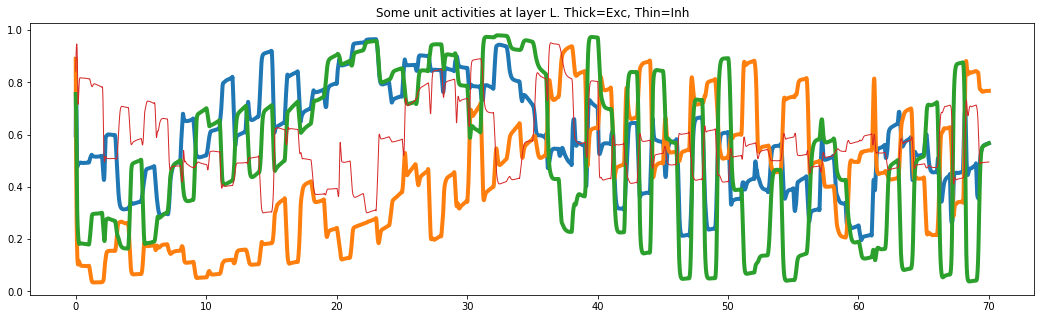

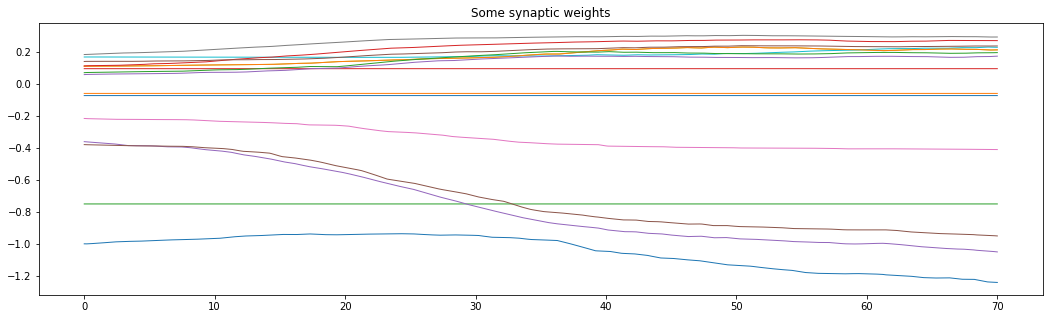

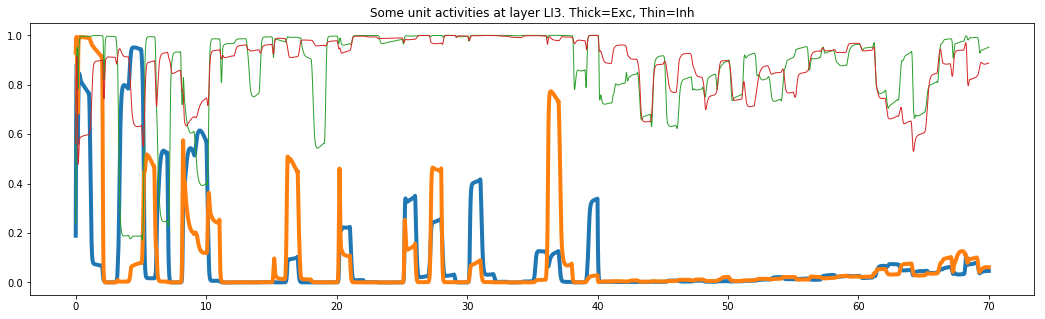

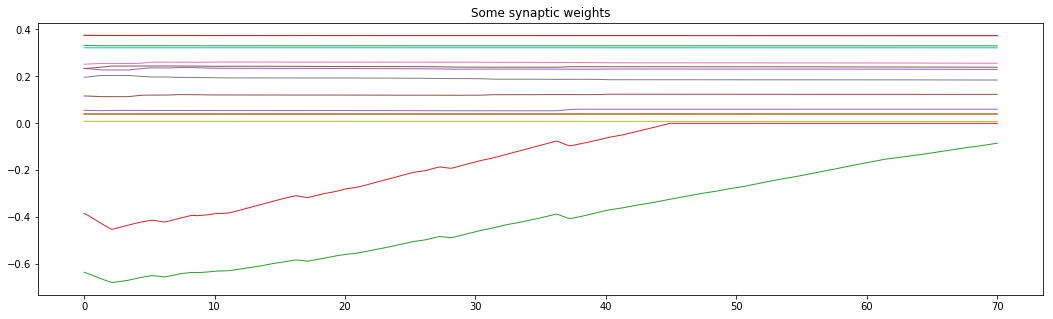

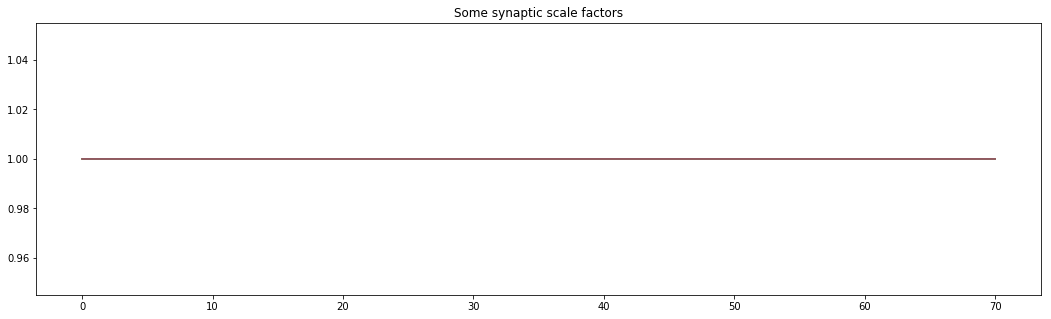

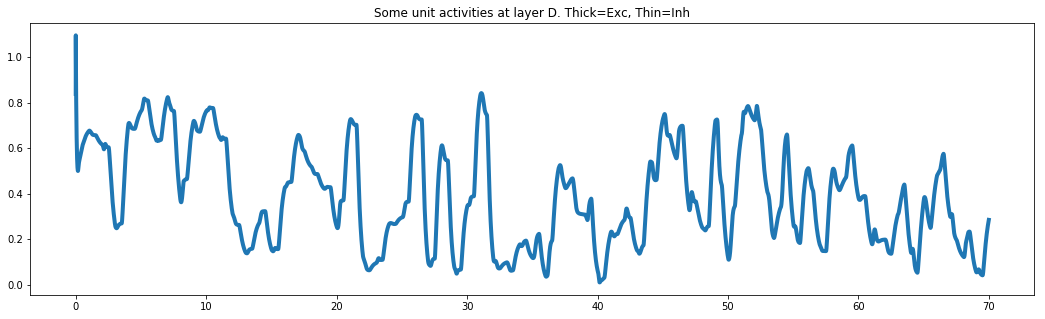

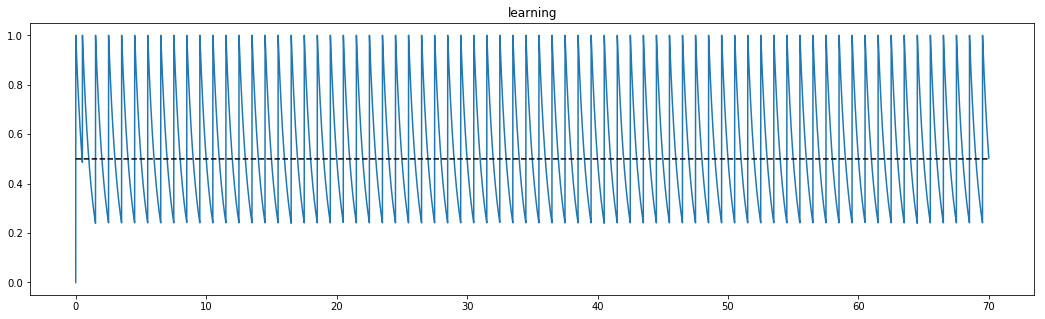

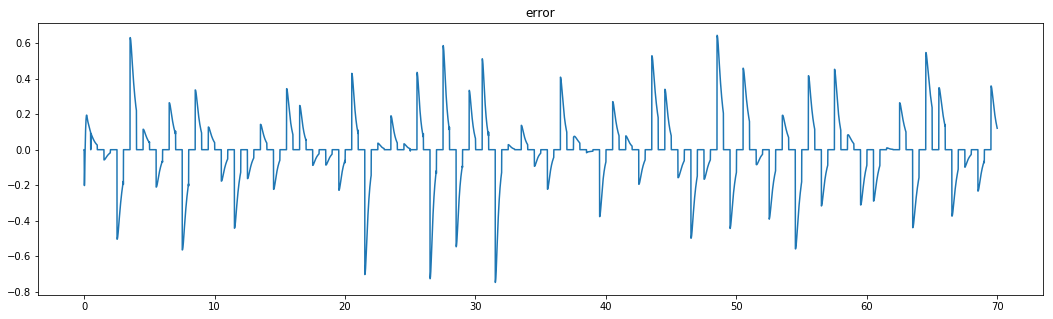

In [26]:
# basic plot 
%matplotlib inline
net_num = 12
net = s1p4_obj.nets[net_num]
L = net.layers['L']
LI3 = net.layers['LI3']
#shrp = net.layers['shrp']
I1 = net.layers['I1']
I2 = net.layers['I2']
I3 = net.layers['I3']
D = net.layers['D']
des = net.layers['des']
print(L.notes)
print(LI3.notes)
net.basic_plot('L')
net.basic_plot('LI3')
net.basic_plot('D')

[ 1.25603667  1.09855946  1.03254169  1.10342505  0.93512997  0.95491356
  1.30128133  1.22847622  0.87997767  1.00784496]


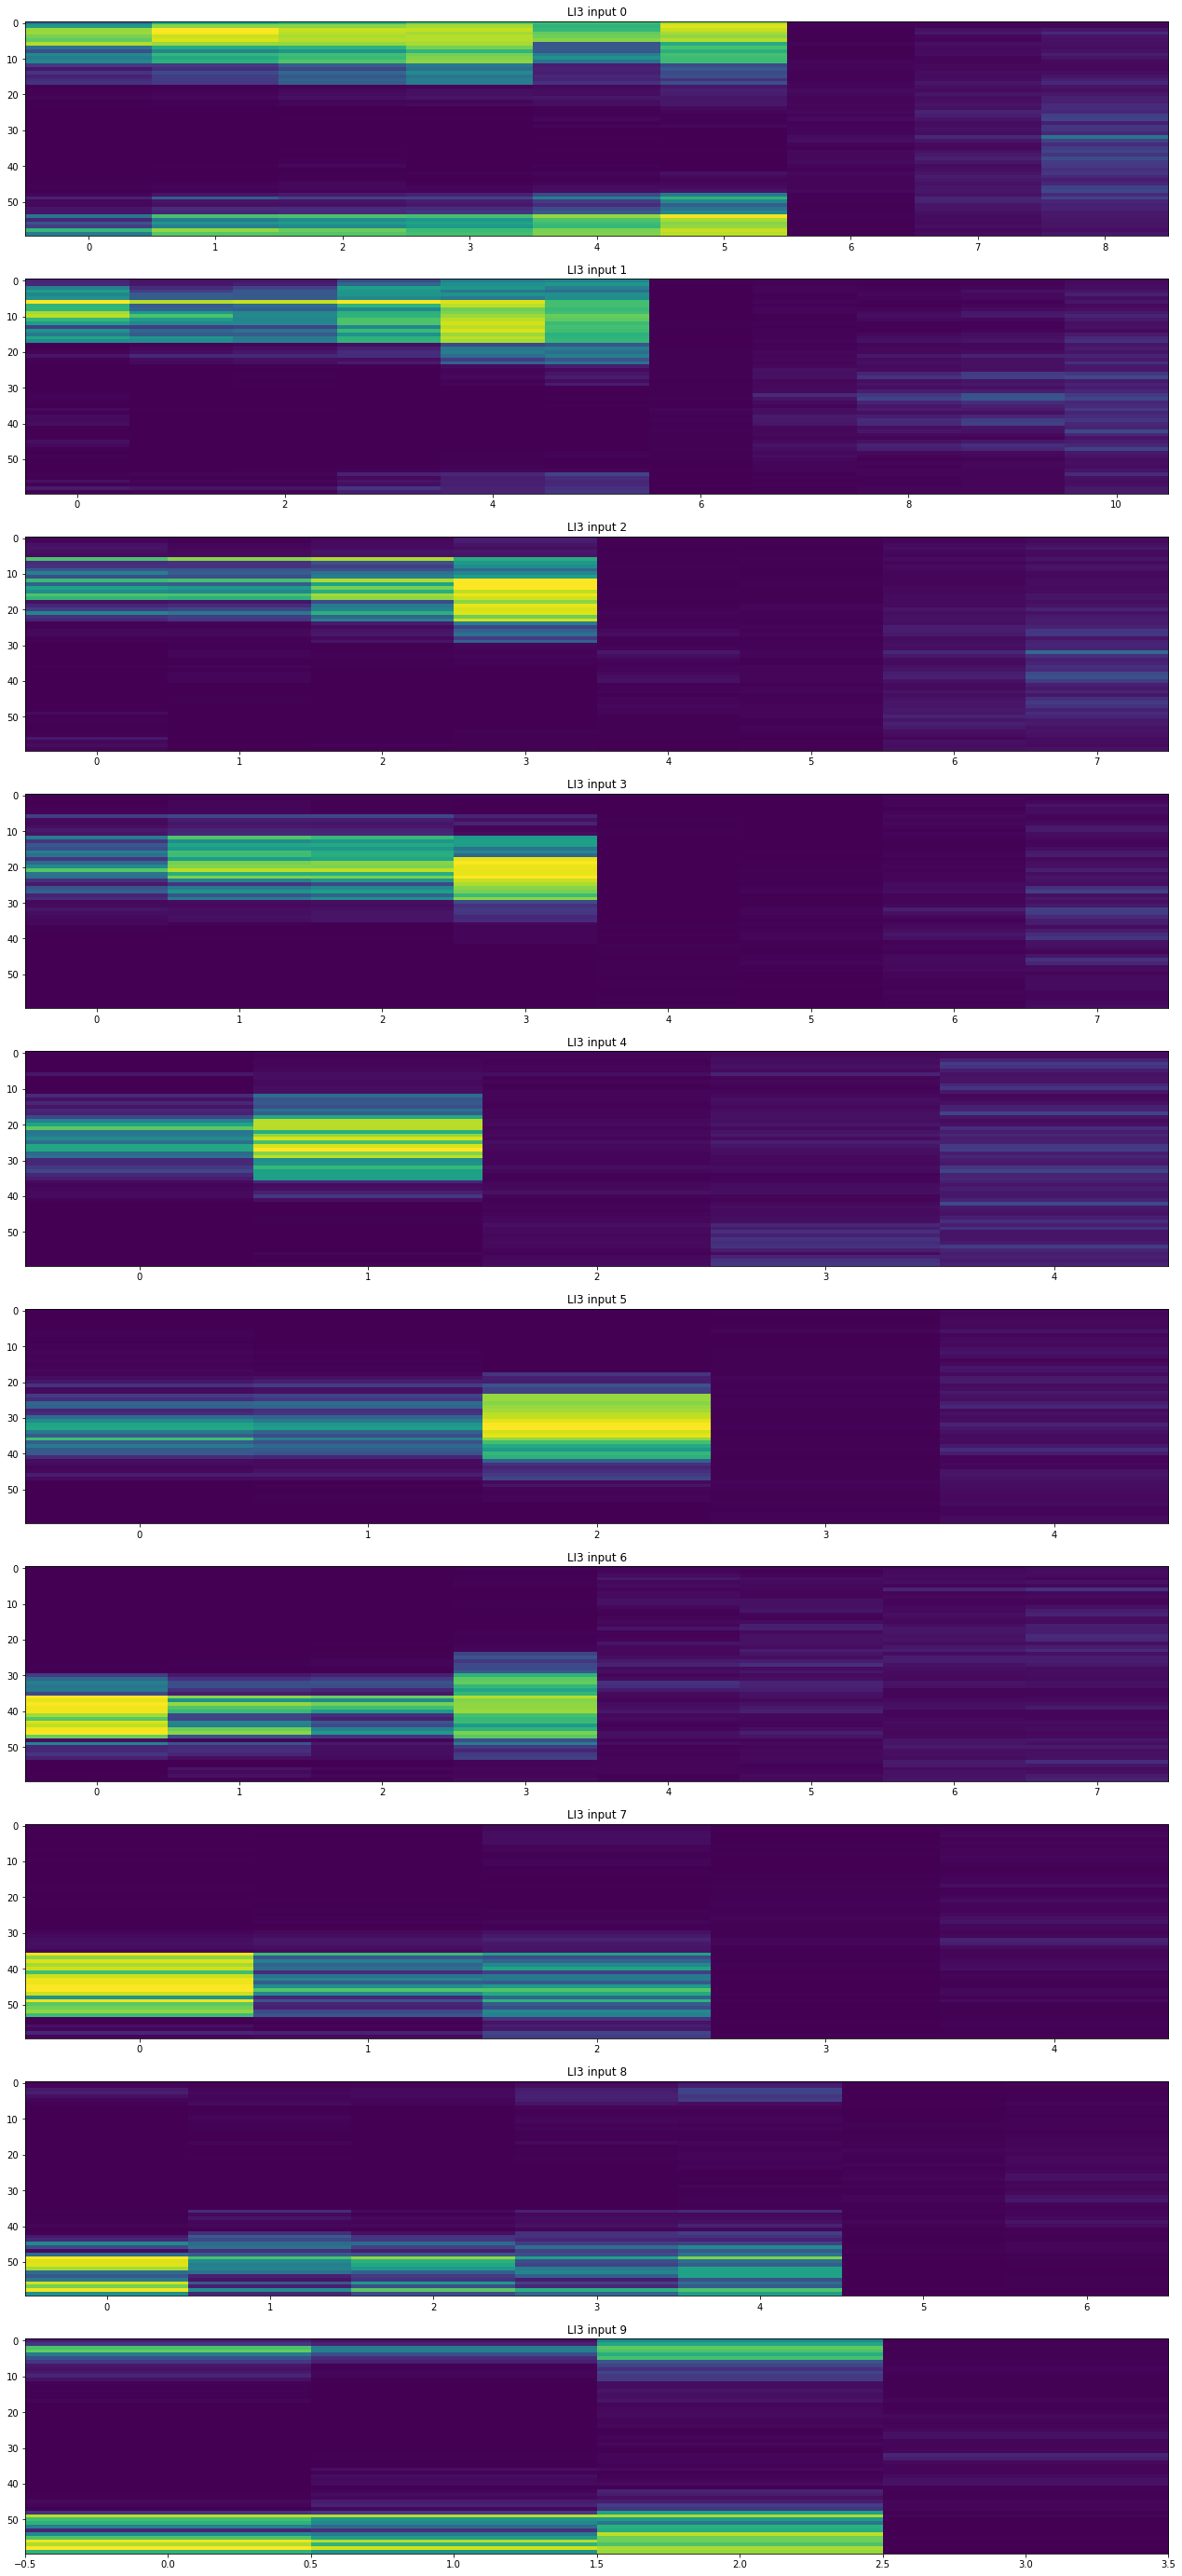

In [27]:
start_time = 0
s1p4_obj.I3_LI3_compare2(start_time, net_num)

    norm of output matrix: 17.879318
    norm of input matrix: 68.718427
    norm of difference between matrices: 67.474450


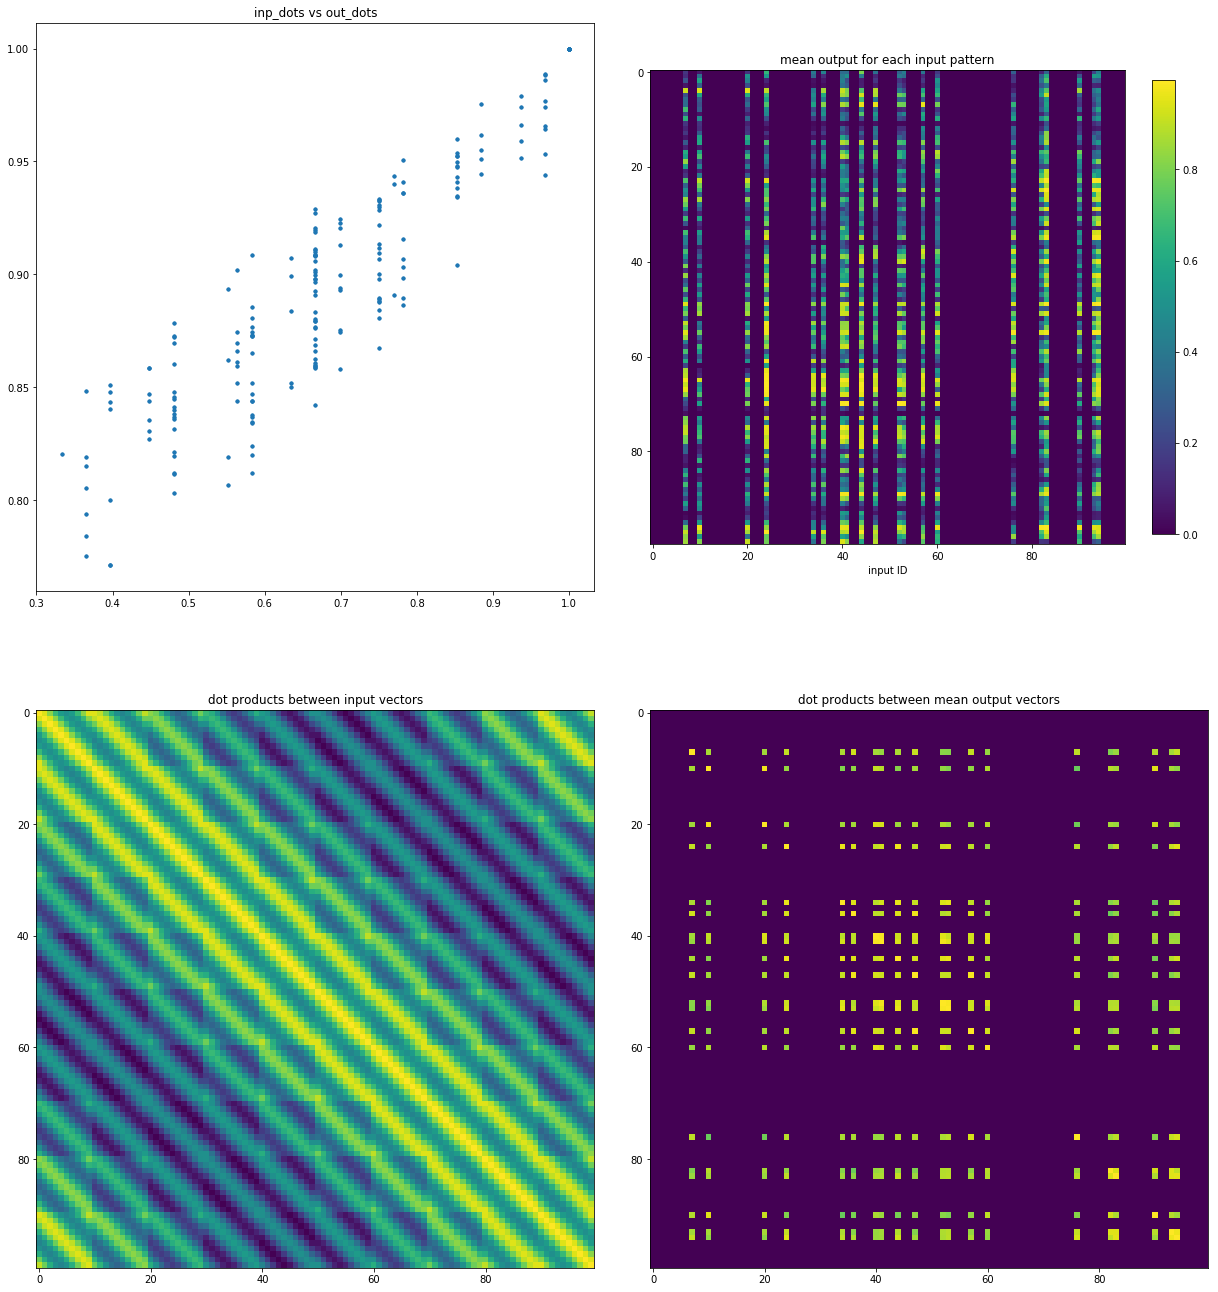

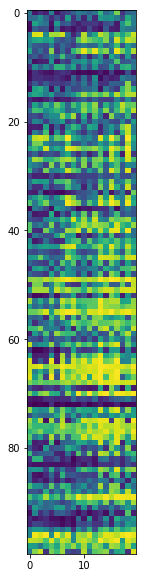

In [68]:
# input-output analysis for I1,2->L
#s1p4_obj.io_compare(net_num=net_num)
s1p4_obj.io_compare(net_num=net_num, make_history=True)

In [8]:
# input-output analysis for I3->LI3
s1p4_obj.I3_LI3_compare(0., 10, net_num)
#s1p4_obj.I3_LI3_compare(280., 10, net_num, make_history=True)

ValueError: operands could not be broadcast together with shapes (10,200) (60,200) 

norm of error in first part: 10.3499415184
std dev for desired value (first part): 10.4740932782
norm of error in second part: 12.7184315924
std dev for desired value (second part): 12.9905213281


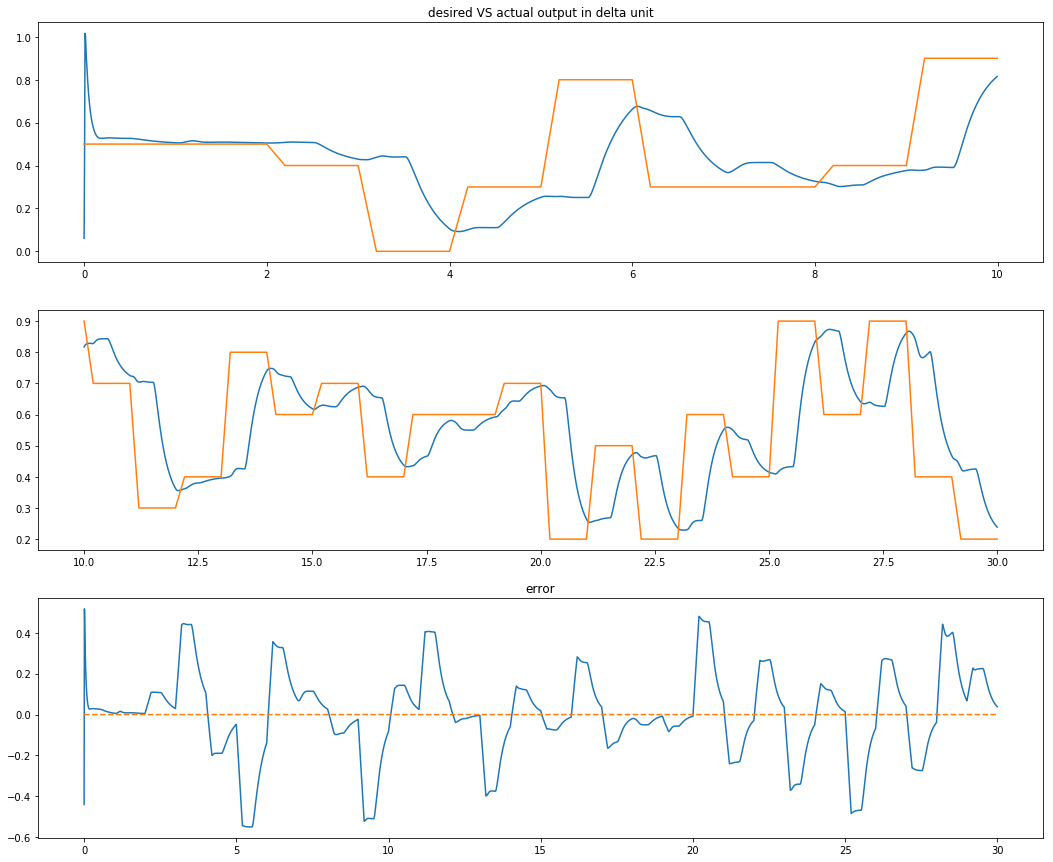

In [55]:
# compare output of the delta unit with the desired output
start_t = 0.
middle_t = 10.
end_t = 30.
s1p4_obj.des_D_compare(start_t, middle_t, end_t, net_num, make_history=False)

In [48]:
#net.double_anim(LI3.e, slider=False, interv=10, nbins=20, thr=0.7, pdf=True)
net.double_anim(L.e+LI3.e+I1.x+I2.x+I3.x, slider=True, interv=10, nbins=20, thr=0.7, pdf=True)

interactive(children=(IntSlider(value=4000, description='frame', max=8000, min=1), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

[ 9  0 10 11  8  6  7]


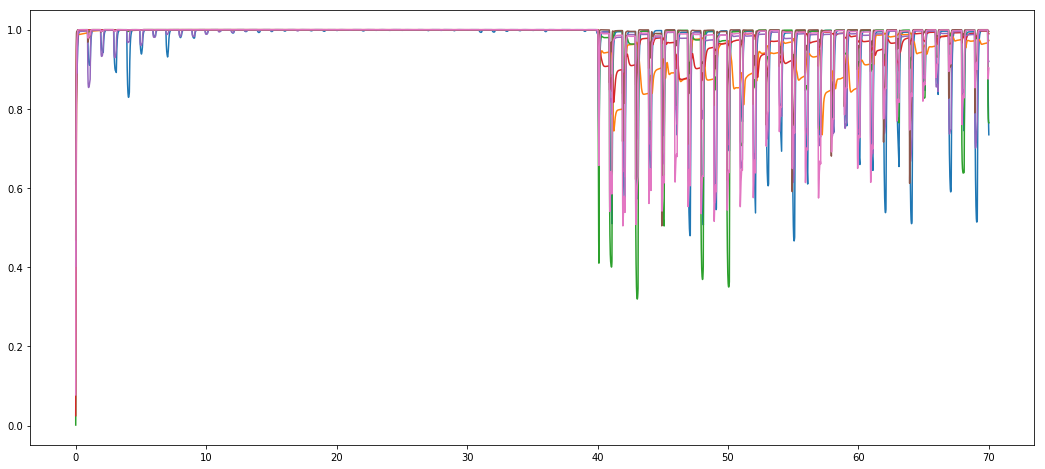

In [19]:
# Plot the highest unit activities (LI3)
%matplotlib inline
n_top = 7  # how many units to plot
top_pop = np.array(LI3.i)  # population to visualize
top_units = net.all_activs[top_pop].sum(1).argpartition(-n_top)[-n_top:]
print(top_units)
top_act_fig = plt.figure(figsize=(18,8))
top_acts = net.all_activs[top_pop[top_units]].transpose()
plt.plot(net.all_times, top_acts)
plt.show()

[38 22 25 34 48]


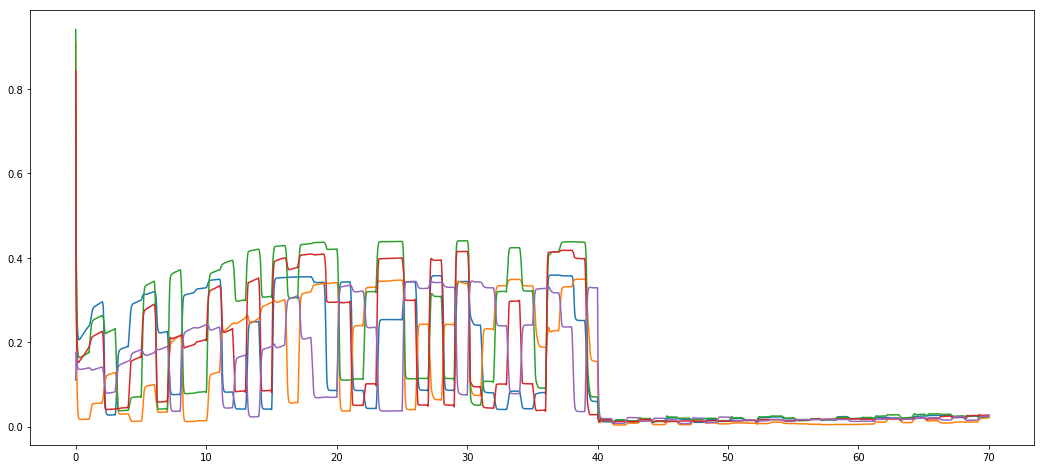

In [20]:
# Plot the lowest unit activities (LI3)
n_bottom = 6  # how many units to plot
bottom_pop = np.array(LI3.e)  # population to visualize
bottom_units = net.all_activs[bottom_pop].sum(1).argpartition(n_bottom)[0:n_bottom-1]
print(bottom_units)
bottom_act_fig = plt.figure(figsize=(18,8))
bottom_acts = net.all_activs[bottom_pop[bottom_units]].transpose()
plt.plot(net.all_times, bottom_acts)
plt.show()

In [ ]:
# Annotations for individual networks
"""
# 0
#net.annotate("The standard configuration has sigmoidal units in the L layer, and sig_trdc in the LI3 layer.") 
#net.annotate("The L representation is not bad for using sigmoidals. LI3 has a so-so performance, and D barely")
#net.annotate("improves over random behaviour.")
net.annotate("....................")
net.annotate("After removing the I3-LI3 connections for 30 presentations the LI3 representation dropped its ")
net.annotate("performance sharply, but it seemeed to at least respond. I also noticed that in LI3 the ")
net.annotate("inhibitory units are always saturated.")
net.annotate("Same results after another 30 presentations without I3-LI3 connections. ")

# 1
#net.annotate("The L representation worsens a bit, but LI3 is following I3 quite well, with two caveats. First, the cusp of the")
#net.annotate("cosine is too wide (too many active units), and second, LI3 units don't seem to go below 0.7. ")
#net.annotate("The delta unit seems to have learned a bit.")
net.annotate("....................")
net.annotate("After removing the I3-LI3 connections the LI3 activity became stationary.")
net.annotate("Somehow the stationary activity still got a mean dot product of 0.81, which is strange.")
net.annotate("---Inhibitory units are always saturated.---")
net.annotate("Same results after another 30 presentations without I3-LI3 connections. ")

# 2
#net.annotate("The L representation recovers, the LI3 representation is almost perfect, without the caveats of the ds units,")
#net.annotate("although they might reach their steady values too slowly, which gives the ds units the better score.")
#net.annotate("in the LI3-I3 comparison.")
net.annotate("....................")
net.annotate("After removing the I3-LI3 connections the LI3 activity disappeared for the sds configuration.")
net.annotate("It seemed to be coming back, as the means were updated, but this would require more time, it seems.")
net.annotate("---Inhibitory units are always above 0.8.---")
net.annotate("After 30 more presentations, all LI3 units went to a steady value of ~0.2. ")

# 3
#net.annotate("The LI3 representation worsens wrt sds units, as the trdc component allows some opportunistic units to hold")
#net.annotate("to a high activity.")
net.annotate("....................")
net.annotate("After removing the I3-LI3 connections the LI3 activity was still maintained for the sds_trdc configuration.")
net.annotate("The relation between LI3 activity and I3, however, became tenuous ")
net.annotate("---Inhibitory units are always above 0.6 or so.---")
net.annotate("Same results after another 30 presentations without I3-LI3 connections. ")

# 4
#net.annotate("The sds_sharp unit removes the caveats of the ds, and to some extent those of the sds and sds_sharp units, to bring a ")
#net.annotate("LI3 representation that rivals that of sds.")
net.annotate("....................")
net.annotate("After removing the I3-LI3 connections the LI3 activity in the sds_sharp configuration became smaller,")
net.annotate("and the same pattern would repeat often with every shift of the threshold.")
net.annotate("---Inhibitory units are always above 0.6 or so.---")
net.annotate("After another 30 presentations without I3-LI3 connections the LI3 activity recovered until it could raise to 0.8 or so. ")
net.annotate("LI3 was responsive, but the relation with I3 was largely lost. ")

# 5
#net.annotate("The ds_n units in LI3 follow I3 very well with two caveats. First, you need to wait until the mean of the inputs is ")
#net.annotate("obtained, and second, with these parameters, the LI3 outputs do not go past 0.8.")
net.annotate("....................")
net.annotate("After removing the I3-LI3 connections the LI3 activity in the ds_n configuration settled into a very weak,")
net.annotate("fixed pattern.")
net.annotate("---Inhibitory units are always above 0.8 or so.---")
net.annotate("After another 30 presentations without I3-LI3 connections activity never came back.")

# 6
#net.annotate("The sds_n units fix the problem with the activation ranges of the ds_n units!")
#net.annotate("These are another solid option.")
net.annotate("....................")
net.annotate("After removing the I3-LI3 connections the LI3 activity in the sds_n configuration was squashed into a very weak,")
net.annotate("fixed pattern. The network seemd on the way to recover, perhaps.")
net.annotate("---Inhibitory units are always above 0.7 or so.---")
net.annotate("After another 30 presentations without I3-LI3 connections there were glimpses of activity coming back, but only")
net.annotate("for brief moments. There might have been a trace left of the relation with I3 activity, but it is hard to verify.")

# 7
#net.annotate("The sds_n_sharp seem to be a slight improvement over the already good sds_n!")
net.annotate("....................")
net.annotate("After removing the I3-LI3 connections the LI3 activity in the sds_n_sharp configuration showed a weakened, repeating")
net.annotate("pattern that changed a couple of times, similar to sds_sharp. The network seemd on the way to improve, perhaps.")
net.annotate("---Inhibitory units are always above 0.7 or so.---")
net.annotate("After another 30 presentations responsivenes largely recovered, but the relation with the I3 activity ")
net.annotate("was greatly lost.")

# 8
#net.annotate("I saw good things in LI3 up until network 7, but this just takes it to another level, and the mean dot product")
#net.annotate("of 0.91 just confirms it. The steady state activation favors only one winner unit, which is usually the one right in")
#net.annotate("the center. What keeps this from being perfect is that the activation levels only reach up to 0.8 or so, so an ")
#net.annotate("adjustment in slopes (or threshold?) could be good.")
net.annotate("....................")
net.annotate("After removing the I3-LI3 connections the LI3 activity in the ds_ssrdc_sharp configuration settled into a")
net.annotate("a fixed pattern.")
net.annotate("---Inhibitory units are always above 0.9 or so.---")
net.annotate("Same results after another 30 presentations without I3-LI3 connections. ")

# 9
#net.annotate("Oja synapses do not seem to affect things for sds units. Their effect should be seen after the I3 inputs are removed.")
net.annotate("....................")
net.annotate("Oja synapses did not save the sds configuration, which was similar to network 2.")
net.annotate("It seemed to be coming back, as the adaptive inhibition got weaker.")
net.annotate("---Inhibitory units are always above 0.6.---")
net.annotate("After another 30 presentations, all LI3 units went to a steady value of ~0.2. ")

# 10
#net.annotate("sds_trdc units with Oja L-LI3 synapses are still as in network 3.")
net.annotate("....................")
net.annotate("Oja synapses did not save the sds_trdc configuration, which was similar to network 3.")
net.annotate("---Inhibitory units are always above 0.7.---")
net.annotate("Same results after another 30 presentations without I3-LI3 connections. ")

# 11
net.annotate("sds_sharp units with Oja L-LI3 synapses are still as in network 4.")
net.annotate("....................")
net.annotate("Oja synapses did not save the sds_sharp configuration, which was similar to network 4.")
net.annotate("---Inhibitory units are always above 0.7.---")
net.annotate("After another 30 presentations without I3-LI3 connections the response was still repetitive, and ")
net.annotate("largely unrelated to the I3 pattern.")

# 12
#net.annotate("ds_n units with Oja L-LI3 synapses are still as in network 5.")
net.annotate("....................")
net.annotate("Oja synapses did not save the ds_n configuration. Activity was squashed.")
net.annotate("---Inhibitory units are always above 0.6.---")
net.annotate("After another 30 presentations without I3-LI3 connections the response was still squashed.")

# 13
#net.annotate("sds_n units with Oja L-LI3 synapses are as in network 6.")
net.annotate("....................")
net.annotate("Oja synapses did not save the sds_n configuration. Activity was squashed, but it seemed to be going up.")
net.annotate("---Inhibitory units are always above 0.7.---")
net.annotate("After another 30 presentations without I3-LI3 connections the response is still largely squashed")
net.annotate("with brief glimpses of activity, but not much relation with I3.")

# 14
#net.annotate("sds_n_sharp units with Oja L-LI3 synapses are as in network 7.")
net.annotate("....................")
net.annotate("Oja synapses did not save the sds_n_sharp configuration. Similar to network 7.")
net.annotate("---Inhibitory units are always above 0.6.---")
net.annotate("After another 30 presentations without I3-LI3 connections responsiveness was recovered at some point,")
net.annotate("but the relation of the LI3 response with I3 seems to be lost.")

"""

In [ ]:
print(s1p4_obj.nets[14].notes)

In [ ]:
s1p4_obj.nets[0].history

In [52]:
# Visualize the connections
#ei_net.conn_anim(I1.x+I2.x, L.e, slider=False)
net.conn_anim(I3.x, LI3.i, slider=True)

interactive(children=(IntSlider(value=8, description='frame', max=15, min=1), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

In [10]:
# log all networks
s1p4_obj.log() 

In [9]:
# saving
for net in s1p4_obj.nets:
    net.history.append('s1p4_obj object saved with name: ' + s1p4_obj.name)
F = open(s1p4_obj.name+'.pkl', 'wb')
dill.dump(s1p4_obj, F)
F.close()

In [ ]:
# loading
#F = open("/media/z/data/pickles/exp_dist_sig_test4.pkl", 'rb')
#F = open("/home/z/projects/draculab/sig_ssrdc_test1.pkl", 'rb')
F = open("/home/z/projects/draculab/sig_trdc_test1.pkl", 'rb')
mp_net_obj = dill.load(F)

In [ ]:
# Write the configuration of the mp_net_runner object in the simulation log
f = open(log_file, mode='a')
f.write(runner.stdout)
f.close()

In [ ]:
s1p4_obj.code = str(runner)

In [ ]:
# Continue running after loading
s1p4_obj.run_all(save=True, log=False, save_interv=10)

In [ ]:
print(s1p4_obj.code)

In [ ]:
# DEPRECATED
# Compare the output of the delta unit with the desired output.
# This is done from start_t to middle_t, and then from middle_t to end_t, to see if things are improving.
# The norm of the difference between delta output and desired value is compared with the norm of the 
# difference between the desired value and its mean.
%matplotlib inline
start_t = 20.
middle_t = 150.
end_t = 280.
# change the
st_idx = int(np.floor(start_t / s1p4_obj.nets[net_num].net.min_delay))
mid_idx = int(np.floor(middle_t / s1p4_obj.nets[net_num].net.min_delay))
end_idx = int(np.floor(end_t / s1p4_obj.nets[net_num].net.min_delay))

times1 = net.all_times[st_idx:mid_idx]
delta1 = net.all_activs[D.e[0]][st_idx:mid_idx]
des1 = net.all_activs[des.x[0]][st_idx:mid_idx]
times2 = net.all_times[mid_idx:end_idx]
delta2 = net.all_activs[D.e[0]][mid_idx:end_idx]
des2 = net.all_activs[des.x[0]][mid_idx:end_idx]

cmp_fig, cmp_axes = plt.subplots(3,1, figsize=(18,15))
plt0 = cmp_axes[0].plot(times1, delta1, times1, des1) 
cmp_axes[0].set_title('desired VS actual output in delta unit')
plt1 = cmp_axes[1].plot(times2, delta2, times2, des2)

# compare norm of (delta-des) against standard deviation of des (norm of des - <des>)
# e.g. is delta better than a static value?
diff_vec1 = delta1 - des1
des_mean1 = np.mean(des1)
des_shift1 = des1 - des_mean1
norm_diff1 = np.linalg.norm(diff_vec1)
norm_shift1 = np.linalg.norm(des_shift1)
print("norm of error in first part: " + str(norm_diff1))
print("std dev for desired value (first part): " + str(norm_shift1))

diff_vec2 = delta2 - des2
des_mean2 = np.mean(des2)
des_shift2 = des2 - des_mean2
norm_diff2 = np.linalg.norm(diff_vec2)
norm_shift2 = np.linalg.norm(des_shift2)
print("norm of error in second part: " + str(norm_diff2))
print("std dev for desired value (second part): " + str(norm_shift2))

plt3 = cmp_axes[2].plot(net.all_times, net.all_activs[D.e[0]] - net.all_activs[des.x[0]], net.all_times, np.tile(0, (len(net.all_times), 1)), '--')
cmp_axes[2].set_title('error')


In [ ]:
# Continue running after loading
s1p4_obj.run_all(save=True, log=False, save_interv=10)

In [ ]:
# mean activity given the rate distribution
c = 3
a = np.exp(-c)
b = 1-a
mean = (b/c**3)*(1. - (c+1.)*a)
print(mean)

n_points = 1000
r = np.linspace(0.,1.,n_points)
pdf = (b/c)*np.exp(-c*r)
mean2 = np.dot(r,pdf)/n_points
print(mean2)

In [ ]:
log_file